In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from scipy import stats
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
from pytz import timezone
from collections import deque
import MySQLdb
import time
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import Queue
est = timezone('US/Eastern')

Using TensorFlow backend.


In [22]:
btc = pd.read_csv('binance-data.csv')
twitter_sent = pd.read_csv('live_tweet.csv')
reddit_sent = pd.read_csv('live_reddit.csv')

btc.columns = ["Price","Volume", "Number_Trades", "Market_Cap","Supply", "Stamp"]
twitter_sent.columns = ["Sentiment", "Stamp"]
reddit_sent.columns = ["Sentiment", "Stamp"]

merged = pd.merge(twitter_sent, btc,  on='Stamp', how='inner').merge(reddit_sent, on='Stamp', how='inner')
data = merged[["Sentiment_x", "Sentiment_y","Volume", "Market_Cap", "Supply", "Number_Trades", "Price"]].groupby(merged['Stamp']).mean()
datag = data[["Volume", "Market_Cap", "Supply", "Number_Trades", "Price"]]
tw_sentiment = data["Sentiment_x"]
rdt_sentiment = data["Sentiment_y"]

print "Dataset size: " + str(len(datag))
print "Timespan: " + str(len(datag)/60) + " hours"

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
values = datag.values.reshape(-1, datag.shape[1])
tw_sentiment = tw_sentiment.values.reshape(-1, 1)
rdt_sentiment = rdt_sentiment.values.reshape(-1, 1)
tw_sentiment = tw_sentiment.astype('float32')
rdt_sentiment = rdt_sentiment.astype('float32')
values = values.astype('float32')
scaled = scaler.fit_transform(values)

Dataset size: 11263
Timespan: 187 hours


7880
3375
Done


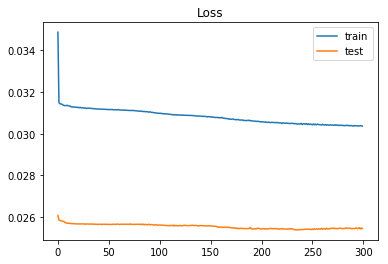

In [23]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
split = train_size

def create_dataset(dataset, look_back, tw_sentiment, rdt_sentiment, sent=False):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        if i >= look_back:
            a = dataset[i-look_back:i+1, 0]
            a = a.tolist()
            if(sent==True):                
                current_tw_sentiment = tw_sentiment[i].tolist()[0]
                current_rdt_sentiment = rdt_sentiment[i].tolist()[0]
                a.append(current_tw_sentiment)
                a.append(current_rdt_sentiment)
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

look_back = 2
trainX, trainY = create_dataset(train, look_back, tw_sentiment[0:train_size], rdt_sentiment[0:train_size], sent=True)
testX, testY = create_dataset(test, look_back, tw_sentiment[train_size:len(scaled)], rdt_sentiment[train_size:len(scaled)], sent=True)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Creating new model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.save('models/LSTM_Philip_V5_{0}'.format(datetime.now()) + '.h5')

# Loading model
# model = load_model('models/LSTM_12-03-2018_GOOD.h5')

history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)
yhat = model.predict(testX)
# yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
# testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
# rmse_sent = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print "Done"
# print 'Test RMSE: %.3f' % rmse_sent

pyplot.title("Loss")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [19]:
#Enter the values for you database connection
dsn_database = "ai_datasets_v5" # e.g. "MySQLdbtest"
dsn_hostname = "127.0.0.1"      # e.g.: "mydbinstance.xyz.us-east-1.rds.amazonaws.com"
dsn_port = 3306                 # e.g. 3306 
dsn_uid = "root"                # e.g. "user1"
dsn_pwd = ""                    # e.g. "Password123"


In [24]:
true_q = Queue.Queue()
pred_q = Queue.Queue()

def process_data(in_data):
    out_data = []
    for line in in_data:
        out_data.append(float(line.split(',')[0]))
    return np.array(out_data).reshape(-1,1)

def get_last_trade():
    conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)
    cursor = conn.cursor()
    cursor.execute ("select * from trades order by date desc limit 1")
    return cursor.fetchone()

    

In [25]:
diffs = deque([], maxlen=200)
lows = []
tops = []
last_trade = ()
top_lows = deque([], maxlen=30)
top_tops = deque([], maxlen=30)
bought = False
to_db = False
prev = 8515
in_cooldown = False
minute_ = 0
status = 0
current_decision = 0

while True:
    
    # Processing data
    minute_ = minute_ + 1
    btc = open('binance-data.csv','r')
    tw_sent = open('live_tweet.csv','r')
    rdt_sent = open('live_reddit.csv','r')
    bit_data = btc.readlines()
    tw_sent_data = tw_sent.readlines()
    rdt_sent_data = rdt_sent.readlines()
    bit_data = process_data(bit_data[len(bit_data)-5:])
    tw_sent_data = process_data(tw_sent_data[len(tw_sent_data)-5:])
    rdt_sent_data = process_data(rdt_sent_data[len(rdt_sent_data)-5:])
    
    # Last price recieved
    real_price = bit_data[len(bit_data) - 1][0]
    
    # Scaling prices
    live = scaler.fit_transform(bit_data)
    
    # Creating datasets and making prediction
    testX, testY = create_dataset(live, 2, tw_sent_data, rdt_sent_data, sent=True)
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    yhat = model.predict(testX)
    
    #Re scaling prices
    yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
    
    # Save real price and prediction price
    true_q.put(bit_data[4])
    pred_q.put(yhat_inverse[0])
    
    # Diference between real price and prediction
    alpha_diff = 100 * ((yhat_inverse[0][0] - float(real_price))/float(real_price))
    diffs.append(alpha_diff)
    diff_analisis = stats.describe(diffs)
    
    print "#######################################"
    print "In Cooldown ", in_cooldown
    print "#######################################"
    print "Minute: ", minute_
    print "#######################################"
    print "Diff analysis ", diff_analisis
    print "#######################################"
    print "########---> Initial values <---#######"
    print "#######################################"
    print "Pred: " + str(yhat_inverse[0][0])
    print "Real price: " + str(real_price)
    print "Diff: " + str(alpha_diff)

    if(len(diffs) >= 200):
        
        # Sorting all diffs
        sorted_diffs = sorted(diffs)
        # Taking the highest 75 (most negative)
        tops = sorted_diffs[0:75]
        # Taking the lowest 75 (most positive)
        lows = sorted_diffs[-75:]
        # Analyzing lists
        low_analisis = stats.describe(lows)
        top_analisis = stats.describe(tops)
        
        # Getting averages of tops and lows
        top_threshold = top_analisis.mean
        low_threshold = low_analisis.mean
        
        print "#######################################"
        print "######---> Averages (Phase 2) <---#####"
        print "#######################################"
        print "Average low: " + str(low_threshold)
        print "Average top: " + str(top_threshold)
        print "#######################################"
        print "#######################################"
        print "Top analysis", top_analisis
        print "#######################################"
        print "#######################################"
        print "Low analysis", low_analisis
        print "#######################################"
        print "#######################################"
        print "Low length", len(top_lows)
        print "Top length", len(top_tops)
        print "#######################################"
        print "#######################################"
        print "Low break: ", alpha_diff > low_threshold
        print "#######################################"
        print "Top break: ", alpha_diff < top_threshold 
        
        # If diff is greater than the average low
        if(alpha_diff > low_threshold):
            # Adding to top_lows list
            top_lows.append(alpha_diff)
            # Sorting
            sorted_lows = sorted(top_lows)
            top_lows = deque(sorted_lows, maxlen=30)
            
        # If diff is lower than the average high
        if(alpha_diff < top_threshold):
            # Adding to top_tops list
            top_tops.append(alpha_diff)            
            # Sorting 
            sorted_tops = sorted(top_tops)
            top_tops = deque(sorted_tops, maxlen=30)
             
        if(len(top_tops) >= 30 and len(top_lows) >= 30):
            # Analyzing top_tops and top_lows
            alpha_top_analisis = stats.describe(top_tops)
            alpha_low_analisis = stats.describe(top_lows)

            # Getting averages of top_tops and top_lows analisis
            alpha_top = alpha_top_analisis.mean
            alpha_low = alpha_low_analisis.mean

            print "####################################"
            print "####---> Signals (Phase 3) <---#####"
            print "Buy: " + str(alpha_top - alpha_top_analisis.variance)
            print "####################################"
            print "Sell: " + str(alpha_low)

            if(not in_cooldown):
                if bought:
                    status = ((real_price - buy_price) / buy_price) * 100
                    print "####################################"
                    print "Current status"
                    print "####################################"
                    print "Status", status
                    print "####################################"
                    if status >= 0.15:
                        alpha_low = 0.10
                # If difference is lower that than the lowest top (negative value) -> BUY
                if alpha_diff < alpha_top - alpha_top_analisis.variance  and not bought:
                    decision = 1
                    print "Buy at: " + str(real_price)
                    bought = True
                    to_db = True
                    in_cooldown = True
                    buy_price = real_price
                # If difference is greater than the average low in the top_lows list -> SELL
                elif alpha_diff > alpha_low and bought and status >= 0.10:
                    decision = 2
                    print "Sell at: " + str(real_price)
                    bought = False
                    to_db = True
                    in_cooldown = True
                    buy_price = 0
                else:
                    to_db = False
                    # Saving decision to DB
                if to_db == True:
                    conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)
                    cursor=conn.cursor()
                    input_string = "INSERT INTO live_data (yhat, bit_data, sent_data, reddit_sent, date, decision) values ({},{},{},{},'{}',{});".format(
                        yhat_inverse[0][0],
                        bit_data[0][0],
                        tw_sent_data[4][0],
                        rdt_sent_data[4][0],
                        datetime.now(tz=est).strftime('%Y-%m-%d %H:%M:%S'),
                        decision)
                    cursor.execute(input_string)
                    current_decision = cursor.lastrowid
                    conn.commit()
                    cursor.close()
                    to_db = False
            else:
                last_trade = get_last_trade()
                if len(last_trade) is not 0 and current_decision == last_trade[3]:
                    in_cooldown = False
                print "####################################"
                print "In Cooldown"
                print "####################################"
                print "Last trade", last_trade
                print "####################################"
                print "Current decision", current_decision
                print "####################################"
    time.sleep(60)

1
#######################################
In Cooldown  False
#######################################
Minute:  1
#######################################
Diff analysis  DescribeResult(nobs=1, minmax=(0.0043563274050595763, 0.0043563274050595763), mean=0.0043563274050595763, variance=nan, skewness=0.0, kurtosis=-3.0)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8518.87
Real price: 8518.5
Diff: 0.00435632740506
1
#######################################
In Cooldown  False
#######################################
Minute:  2
#######################################
Diff analysis  DescribeResult(nobs=2, minmax=(-0.13849292793963905, 0.0043563274050595763), mean=-0.067068300267289743, variance=0.010202954876267455, skewness=2.975543596468573e-16, kurtosis=-2.0)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8519.64
Real price: 8531.46
Diff

1
#######################################
In Cooldown  False
#######################################
Minute:  17
#######################################
Diff analysis  DescribeResult(nobs=17, minmax=(-0.20315217619117243, 0.34343941694306857), mean=0.016920006078727054, variance=0.030813660269897594, skewness=0.7503230455091877, kurtosis=-0.5282211143869571)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8444.46
Real price: 8455.79
Diff: -0.133956843476
1
#######################################
In Cooldown  False
#######################################
Minute:  18
#######################################
Diff analysis  DescribeResult(nobs=18, minmax=(-0.20315217619117243, 0.34343941694306857), mean=0.014268920894987831, variance=0.029127600566453096, skewness=0.8136842458815071, kurtosis=-0.35463599010948776)
#######################################
########---> Initial values <---#######
#####################

1
#######################################
In Cooldown  False
#######################################
Minute:  33
#######################################
Diff analysis  DescribeResult(nobs=33, minmax=(-0.22663262900039782, 0.34343941694306857), mean=-0.036389069583566525, variance=0.021154842396413343, skewness=1.319889637764334, kurtosis=1.3178555631927722)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8458.71
Real price: 8468.0
Diff: -0.109696061644
1
#######################################
In Cooldown  False
#######################################
Minute:  34
#######################################
Diff analysis  DescribeResult(nobs=34, minmax=(-0.22663262900039782, 0.34343941694306857), mean=-0.035553236999442919, variance=0.020537539513914217, skewness=1.3198945536951936, kurtosis=1.4069976903380477)
#######################################
########---> Initial values <---#######
########################

1
#######################################
In Cooldown  False
#######################################
Minute:  49
#######################################
Diff analysis  DescribeResult(nobs=49, minmax=(-0.43969922178632298, 0.34343941694306857), mean=-0.047358675428197675, variance=0.024836441476694716, skewness=0.44967208157876243, kurtosis=0.9540116541903765)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8461.91
Real price: 8480.99
Diff: -0.225029466637
1
#######################################
In Cooldown  False
#######################################
Minute:  50
#######################################
Diff analysis  DescribeResult(nobs=50, minmax=(-0.43969922178632298, 0.34343941694306857), mean=-0.047581762766741156, variance=0.024332063722140029, skewness=0.45849423058881483, kurtosis=1.0365181032497066)
#######################################
########---> Initial values <---#######
####################

1
#######################################
In Cooldown  False
#######################################
Minute:  65
#######################################
Diff analysis  DescribeResult(nobs=65, minmax=(-0.43969922178632298, 0.34343941694306857), mean=-0.041570970288333321, variance=0.019806476446033359, skewness=0.3852410265940941, kurtosis=1.6085713997932425)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8459.3
Real price: 8460.0
Diff: -0.00821882387707
1
#######################################
In Cooldown  False
#######################################
Minute:  66
#######################################
Diff analysis  DescribeResult(nobs=66, minmax=(-0.43969922178632298, 0.34343941694306857), mean=-0.039581411754561834, variance=0.019763012072300686, skewness=0.35036927756930547, kurtosis=1.5472570591498824)
#######################################
########---> Initial values <---#######
#####################

1
#######################################
In Cooldown  False
#######################################
Minute:  81
#######################################
Diff analysis  DescribeResult(nobs=81, minmax=(-0.49050275083785627, 0.34343941694306857), mean=-0.039566662225972611, variance=0.025311945612735136, skewness=-0.14078120369983893, kurtosis=0.9985789649884369)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8419.45
Real price: 8421.96
Diff: -0.0298239104971
1
#######################################
In Cooldown  False
#######################################
Minute:  82
#######################################
Diff analysis  DescribeResult(nobs=82, minmax=(-0.49050275083785627, 0.34343941694306857), mean=-0.03978941629654207, variance=0.025003521245850688, skewness=-0.1373799568156885, kurtosis=1.0458380990237632)
#######################################
########---> Initial values <---#######
###################

1
#######################################
In Cooldown  False
#######################################
Minute:  97
#######################################
Diff analysis  DescribeResult(nobs=97, minmax=(-0.49050275083785627, 0.34343941694306857), mean=-0.02820042347995173, variance=0.022889757809243891, skewness=-0.284868221555198, kurtosis=1.2151947881758671)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8375.24
Real price: 8387.61
Diff: -0.147523214301
1
#######################################
In Cooldown  False
#######################################
Minute:  98
#######################################
Diff analysis  DescribeResult(nobs=98, minmax=(-0.49050275083785627, 0.34343941694306857), mean=-0.027714556139684991, variance=0.022676915497701615, skewness=-0.2952963858967544, kurtosis=1.2538372851502642)
#######################################
########---> Initial values <---#######
######################

1
#######################################
In Cooldown  False
#######################################
Minute:  113
#######################################
Diff analysis  DescribeResult(nobs=113, minmax=(-0.50276295143228, 0.34343941694306857), mean=-0.042713729897283774, variance=0.024297727285943711, skewness=-0.3253047001431886, kurtosis=1.015709295471753)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8396.76
Real price: 8417.99
Diff: -0.25215435187
1
#######################################
In Cooldown  False
#######################################
Minute:  114
#######################################
Diff analysis  DescribeResult(nobs=114, minmax=(-0.50276295143228, 0.34343941694306857), mean=-0.044550521286562519, variance=0.024467316647950921, skewness=-0.30500487245789604, kurtosis=0.9383268432885745)
#######################################
########---> Initial values <---#######
#######################

1
#######################################
In Cooldown  False
#######################################
Minute:  129
#######################################
Diff analysis  DescribeResult(nobs=129, minmax=(-0.50276295143228, 0.34343941694306857), mean=-0.049138372632199216, variance=0.024280612620555881, skewness=-0.2319458943295633, kurtosis=0.7188861468970504)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8422.42
Real price: 8436.0
Diff: -0.160931387802
1
#######################################
In Cooldown  False
#######################################
Minute:  130
#######################################
Diff analysis  DescribeResult(nobs=130, minmax=(-0.50276295143228, 0.34343941694306857), mean=-0.049916334437024749, variance=0.024171070011365522, skewness=-0.21877939142227065, kurtosis=0.720207591666318)
#######################################
########---> Initial values <---#######
#######################

1
#######################################
In Cooldown  False
#######################################
Minute:  145
#######################################
Diff analysis  DescribeResult(nobs=145, minmax=(-0.50276295143228, 0.34343941694306857), mean=-0.044055379253099929, variance=0.022959792324300596, skewness=-0.2689413685619824, kurtosis=0.817103080090051)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8416.4
Real price: 8410.99
Diff: 0.06436008499
1
#######################################
In Cooldown  False
#######################################
Minute:  146
#######################################
Diff analysis  DescribeResult(nobs=146, minmax=(-0.50276295143228, 0.34343941694306857), mean=-0.041861168270903082, variance=0.023504374956782009, skewness=-0.2378005939908791, kurtosis=0.7617906913533923)
#######################################
########---> Initial values <---#######
##########################

1
#######################################
In Cooldown  False
#######################################
Minute:  161
#######################################
Diff analysis  DescribeResult(nobs=161, minmax=(-1.1910412871665297, 0.34343941694306857), mean=-0.068504250982098336, variance=0.039401262412232921, skewness=-1.645535670808366, kurtosis=6.640458117932084)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8497.82
Real price: 8485.04
Diff: 0.150575674953
1
#######################################
In Cooldown  False
#######################################
Minute:  162
#######################################
Diff analysis  DescribeResult(nobs=162, minmax=(-1.1910412871665297, 0.34343941694306857), mean=-0.068144389376590175, variance=0.039177513135038013, skewness=-1.6546244734407998, kurtosis=6.702048166740257)
#######################################
########---> Initial values <---#######
######################

1
#######################################
In Cooldown  False
#######################################
Minute:  177
#######################################
Diff analysis  DescribeResult(nobs=177, minmax=(-1.1910412871665297, 0.34343941694306857), mean=-0.063937160139731164, variance=0.037004051313964219, skewness=-1.6828890404357522, kurtosis=7.133797100522322)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8480.25
Real price: 8480.01
Diff: 0.00279563718085
1
#######################################
In Cooldown  False
#######################################
Minute:  178
#######################################
Diff analysis  DescribeResult(nobs=178, minmax=(-1.1910412871665297, 0.34343941694306857), mean=-0.063854003856880726, variance=0.036796219741355364, skewness=-1.6888531686924788, kurtosis=7.193304233934317)
#######################################
########---> Initial values <---#######
###################

1
#######################################
In Cooldown  False
#######################################
Minute:  193
#######################################
Diff analysis  DescribeResult(nobs=193, minmax=(-1.1910412871665297, 0.34343941694306857), mean=-0.067032350680545721, variance=0.035234822503420735, skewness=-1.6307092371681615, kurtosis=7.182521056125825)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8498.78
Real price: 8501.03
Diff: -0.0264411893324
1
#######################################
In Cooldown  False
#######################################
Minute:  194
#######################################
Diff analysis  DescribeResult(nobs=194, minmax=(-1.1910412871665297, 0.34343941694306857), mean=-0.066943071007001267, variance=0.035053805003113753, skewness=-1.6362503811885862, kurtosis=7.237505316191941)
#######################################
########---> Initial values <---#######
###################

1
#######################################
In Cooldown  False
#######################################
Minute:  203
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.34343941694306857), mean=-0.064826299620946035, variance=0.034135047923407817, skewness=-1.6830720920652091, kurtosis=7.546656110125781)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8495.19
Real price: 8504.04
Diff: -0.104086098343
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0878791500944
Average top: -0.231829356557
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.082174445375747709), mean=-0.23182935655738546, variance=0.031423324540584448, skewness=-2.896301351062021, kurtosis=11.133275674891632

1
#######################################
In Cooldown  False
#######################################
Minute:  209
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.3258258160875237), mean=-0.069711017153564703, variance=0.033492223372012894, skewness=-1.7271562854612714, kurtosis=7.644716203831097)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8520.16
Real price: 8513.74
Diff: 0.0754093529988
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0820909655872
Average top: -0.236741871936
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.082836505915940661), mean=-0.23674187193601601, variance=0.0307967915605269, skewness=-2.917599525840059, kurtosis=11.366145886480057)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  215
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.3258258160875237), mean=-0.069631994890361149, variance=0.032868623691514907, skewness=-1.8194467377903842, kurtosis=7.951914325955483)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8508.76
Real price: 8513.64
Diff: -0.0573225362477
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0802375264977
Average top: -0.235016918907
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.082763443422055702), mean=-0.23501691890697535, variance=0.031135000747652866, skewness=-2.8892948736228883, kurtosis=11.17848347517360

1
#######################################
In Cooldown  False
#######################################
Minute:  221
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.27629942414764042), mean=-0.076840360207478406, variance=0.034435100364358311, skewness=-1.8149938623092063, kurtosis=7.10476817187477)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8531.17
Real price: 8559.99
Diff: -0.336672140534
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0757933765824
Average top: -0.248176780699
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.083452444519689015), mean=-0.24817678069919008, variance=0.033030310208759163, skewness=-2.604985420062932, kurtosis=9.147923532177673)


1
#######################################
In Cooldown  False
#######################################
Minute:  227
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.27629942414764042), mean=-0.079414463207606756, variance=0.035320429488022116, skewness=-1.752204960219395, kurtosis=6.596447957664315)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8560.94
Real price: 8567.21
Diff: -0.0731810042301
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0758523064757
Average top: -0.254638175844
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.083452444519689015), mean=-0.2546381758438962, variance=0.033149194539957537, skewness=-2.51243313541199, kurtosis=8.710477657691557)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  233
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.27629942414764042), mean=-0.078857966314472366, variance=0.035350382483198779, skewness=-1.7597476620065988, kurtosis=6.601921438031878)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8566.66
Real price: 8585.0
Diff: -0.213660727286
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0758523064757
Average top: -0.254016194344
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.082763443422055702), mean=-0.25401619434361922, variance=0.03342301978260321, skewness=-2.480452943697912, kurtosis=8.566609188621566)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  239
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.078384906826934678, variance=0.035635590717582634, skewness=-1.7191471140756622, kurtosis=6.5456365484148)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8545.98
Real price: 8544.82
Diff: 0.0135809619161
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0765275210849
Average top: -0.254016194344
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.082763443422055702), mean=-0.25401619434361922, variance=0.03342301978260321, skewness=-2.480452943697912, kurtosis=8.566609188621566)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  245
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.075939684297089444, variance=0.03478182384031215, skewness=-1.778024602151222, kurtosis=7.021563288295702)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8538.46
Real price: 8564.39
Diff: -0.30279995131
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0763833093849
Average top: -0.247998338875
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.082174445375747709), mean=-0.24799833887480696, variance=0.033320142457982385, skewness=-2.5581829257995086, kurtosis=8.971062925708452)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  251
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.075951069123130863, variance=0.034896523425518702, skewness=-1.7728762626178047, kurtosis=6.9588626375999105)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8563.74
Real price: 8563.05
Diff: 0.00809482675566
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.076304309556
Average top: -0.248923933429
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.082174445375747709), mean=-0.24892393342911556, variance=0.033260459660552209, skewness=-2.5510878296353177, kurtosis=8.96090012367703

1
#######################################
In Cooldown  False
#######################################
Minute:  257
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.07544008112213374, variance=0.035034818312937074, skewness=-1.7653453533995136, kurtosis=6.906135111881909)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8552.75
Real price: 8556.7
Diff: -0.046151243324
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.07737279029
Average top: -0.248923933429
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.082174445375747709), mean=-0.24892393342911556, variance=0.033260459660552209, skewness=-2.5510878296353177, kurtosis=8.960900123677034)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  263
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.078978829111335302, variance=0.035373396280300007, skewness=-1.6932269791858878, kurtosis=6.594801643509099)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8563.23
Real price: 8579.21
Diff: -0.186292921347
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0769986386867
Average top: -0.256272795114
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.083452444519689015), mean=-0.25627279511377993, variance=0.031712967434839069, skewness=-2.6626774831448885, kurtosis=9.65895701426451)

1
#######################################
In Cooldown  False
#######################################
Minute:  269
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.091290231302590646, variance=0.038421220436393649, skewness=-1.5658501445696782, kurtosis=5.387670726630466)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8613.24
Real price: 8625.0
Diff: -0.136322463768
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.072101951653
Average top: -0.279023430592
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.094422142015321162), mean=-0.27902343059162354, variance=0.033105530488027349, skewness=-2.4180382474943976, kurtosis=7.806495132473815)


1
#######################################
In Cooldown  False
#######################################
Minute:  275
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.092306545043991689, variance=0.03745659031508812, skewness=-1.6615094989473573, kurtosis=5.693815861502278)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8603.48
Real price: 8596.06
Diff: 0.0863354294002
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0671202163226
Average top: -0.277746885572
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.087672947778106206), mean=-0.27774688557203053, variance=0.033475146608414857, skewness=-2.385551952125427, kurtosis=7.6512664387249)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  281
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.083599528685621677, variance=0.036679529980021164, skewness=-1.7382727861301757, kurtosis=6.260064798687534)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8595.42
Real price: 8584.0
Diff: 0.132980417783
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0733267394597
Average top: -0.264067964022
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.086080005476964247), mean=-0.26406796402213134, variance=0.034129638261000843, skewness=-2.4526241981022245, kurtosis=7.971646871898365)


1
#######################################
In Cooldown  False
#######################################
Minute:  287
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.084908015310282525, variance=0.036478552587152234, skewness=-1.7405961718293592, kurtosis=6.302240698065438)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8577.79
Real price: 8570.78
Diff: 0.0817444014722
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0718591230934
Average top: -0.264961387962
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.087672947778106206), mean=-0.26496138796243274, variance=0.033835197838749553, skewness=-2.4816538140869375, kurtosis=8.10086207945462)

1
#######################################
In Cooldown  False
#######################################
Minute:  293
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.085115208895884698, variance=0.037262222335608601, skewness=-1.6439124360462387, kurtosis=5.9983862346440855)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8548.81
Real price: 8569.99
Diff: -0.247192073007
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0751765993325
Average top: -0.267088309632
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.092322323503776865), mean=-0.26708830963215241, variance=0.033410133958300989, skewness=-2.5064197581673637, kurtosis=8.25473203568104

1
#######################################
In Cooldown  False
#######################################
Minute:  299
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.087684966164213091, variance=0.036200281158469134, skewness=-1.654219444873692, kurtosis=6.3164212121493435)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8575.71
Real price: 8573.01
Diff: 0.0314823425495
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0701963300622
Average top: -0.267087758344
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.094422142015321162), mean=-0.26708775834409137, variance=0.032176316757727565, skewness=-2.6365339739562534, kurtosis=9.079274793627027

1
#######################################
In Cooldown  False
#######################################
Minute:  305
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.082218140991437497, variance=0.036968617504589116, skewness=-1.6332434809601877, kurtosis=6.1956360479116075)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8565.47
Real price: 8540.33
Diff: 0.294319075639
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0770853313796
Average top: -0.26244545978
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.086988208281348386), mean=-0.2624454597799184, variance=0.033126436535726556, skewness=-2.568282187155063, kurtosis=8.690387581214154)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  311
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.074756016758344798, variance=0.038685515292522517, skewness=-1.5527402216469295, kurtosis=5.754863809378147)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8506.44
Real price: 8491.53
Diff: 0.17560329234
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0898375828165
Average top: -0.258729763389
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.083657226906278873), mean=-0.25872976338911169, variance=0.033903140814187577, skewness=-2.5177394920957097, kurtosis=8.386453807629735)


1
#######################################
In Cooldown  False
#######################################
Minute:  317
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.069508972919022624, variance=0.038199337780890102, skewness=-1.6445507179239158, kurtosis=6.1447283049761126)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8491.65
Real price: 8500.0
Diff: -0.0982536764706
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0916085855654
Average top: -0.249287650902
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.082174445375747709), mean=-0.24928765090177915, variance=0.035542246961496174, skewness=-2.455673676933246, kurtosis=7.879823868463665

1
#######################################
In Cooldown  False
#######################################
Minute:  323
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.068000098506722575, variance=0.038288071131955113, skewness=-1.657966631882563, kurtosis=6.154214293691467)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8500.27
Real price: 8502.01
Diff: -0.0204712620898
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0929280838629
Average top: -0.248579921203
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.081707720262867573), mean=-0.24857992120269684, variance=0.035642945494340862, skewness=-2.454825142379103, kurtosis=7.856526987606555)

1
#######################################
In Cooldown  False
#######################################
Minute:  329
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.067878769394791649, variance=0.038308809543891417, skewness=-1.647222842061534, kurtosis=6.179027737384327)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8488.19
Real price: 8485.0
Diff: 0.037566293459
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0922982837691
Average top: -0.247536462329
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.081707720262867573), mean=-0.24753646232881502, variance=0.035909993083977854, skewness=-2.436339806853095, kurtosis=7.756915517618419)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  335
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.069410576788515574, variance=0.038104827388759116, skewness=-1.6405750133262258, kurtosis=6.222351027273721)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8476.1
Real price: 8482.2
Diff: -0.0719314233041
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0905307976483
Average top: -0.247617116753
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.082671972261141272), mean=-0.24761711675282375, variance=0.035853144809450441, skewness=-2.443598052292785, kurtosis=7.783200666194556)


1
#######################################
In Cooldown  False
#######################################
Minute:  341
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.074965919116418506, variance=0.038285057182272902, skewness=-1.5813535122745523, kurtosis=5.9518516417193155)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8478.05
Real price: 8492.01
Diff: -0.164426619846
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0871632919517
Average top: -0.255950922296
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.086988208281348386), mean=-0.25595092229551092, variance=0.034628710921139193, skewness=-2.4750841178992586, kurtosis=8.06922800918634

1
#######################################
In Cooldown  False
#######################################
Minute:  347
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1910412871665297, 0.35756781087536876), mean=-0.07686979056352039, variance=0.037593665466896034, skewness=-1.631469346443446, kurtosis=6.163720392700428)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8495.88
Real price: 8494.99
Diff: 0.0105098711123
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0816707798597
Average top: -0.255906823519
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1910412871665297, -0.083657226906278873), mean=-0.25590682351875366, variance=0.034821358269590756, skewness=-2.446341691148714, kurtosis=7.960154992029425)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  353
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.059229603520101891, variance=0.025788722328785575, skewness=-0.6742524835313575, kurtosis=1.765606850889192)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8492.25
Real price: 8499.83
Diff: -0.0892357001552
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0845039078998
Average top: -0.213532265387
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.08187306544345499), mean=-0.21353226538727152, variance=0.016378049091849711, skewness=-1.5462303446525252, kurtosis=2.8628050153154

1
#######################################
In Cooldown  False
#######################################
Minute:  359
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.061161825297245509, variance=0.026283485676522455, skewness=-0.6847555527882805, kurtosis=1.7719670186443919)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8498.11
Real price: 8533.0
Diff: -0.408936262159
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0843535908996
Average top: -0.216778550701
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.082671972261141272), mean=-0.21677855070054466, variance=0.016776785541738816, skewness=-1.5622540832778575, kurtosis=2.7882791277450

1
#######################################
In Cooldown  False
#######################################
Minute:  365
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.067258674751177361, variance=0.026590986947837594, skewness=-0.602069387219052, kurtosis=1.5866019874852917)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8541.15
Real price: 8555.13
Diff: -0.163371914717
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0816315343355
Average top: -0.225076129657
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.087672947778106206), mean=-0.22507612965683507, variance=0.015796743571871497, skewness=-1.5887871174859123, kurtosis=3.0018055086527

1
#######################################
In Cooldown  False
#######################################
Minute:  371
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.062585480684780453, variance=0.02747701757936612, skewness=-0.6112355316759813, kurtosis=1.4349009322693371)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8521.59
Real price: 8521.99
Diff: -0.00474141016359
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0893973710377
Average top: -0.22399930078
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.086156406176202599), mean=-0.22399930078033686, variance=0.016128410912944348, skewness=-1.5370307121409998, kurtosis=2.844279810754

1
#######################################
In Cooldown  False
#######################################
Minute:  377
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.068114825796091474, variance=0.026839147212184528, skewness=-0.5815777946381717, kurtosis=1.4994623259175892)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8527.16
Real price: 8531.0
Diff: -0.0450448181632
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0824934540062
Average top: -0.227182648664
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.087841698171036792), mean=-0.22718264866350751, variance=0.015577458731631336, skewness=-1.5848441598576604, kurtosis=3.048161392688

1
#######################################
In Cooldown  False
#######################################
Minute:  383
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.065500911634920375, variance=0.02761445085475327, skewness=-0.5959314207941162, kurtosis=1.3311321227730115)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8504.19
Real price: 8530.0
Diff: -0.302608440797
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.087931831857
Average top: -0.229222846944
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.086988208281348386), mean=-0.2292228469442982, variance=0.015557805476570567, skewness=-1.5457547612021838, kurtosis=2.9591113778715545

1
#######################################
In Cooldown  False
#######################################
Minute:  389
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.068586972786796208, variance=0.027557691869417804, skewness=-0.5693363336037287, kurtosis=1.299473181919483)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8531.28
Real price: 8531.0
Diff: 0.00325101101864
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0850161679953
Average top: -0.232253577256
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.089235700155178718), mean=-0.23225357725577042, variance=0.015257625497168519, skewness=-1.5426421737425953, kurtosis=3.0099434458914

1
#######################################
In Cooldown  False
#######################################
Minute:  395
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.064548280920065024, variance=0.027336235878899127, skewness=-0.5832464345741689, kurtosis=1.4249875961943967)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8518.44
Real price: 8524.0
Diff: -0.0651996385206
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0882176618294
Average top: -0.225856589773
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.088222633352872212), mean=-0.22585658977308209, variance=0.01554980312277374, skewness=-1.612374316736702, kurtosis=3.13178023035255

1
#######################################
In Cooldown  False
#######################################
Minute:  401
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.070470403775217891, variance=0.028721180793682632, skewness=-0.585255615354369, kurtosis=1.3431731854019135)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8544.95
Real price: 8548.0
Diff: -0.0356557272169
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0870776659508
Average top: -0.235518613588
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.095509356179709876), mean=-0.23551861358827172, variance=0.016444450732962343, skewness=-1.5750153722529352, kurtosis=2.6678837272087

1
#######################################
In Cooldown  False
#######################################
Minute:  406
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.068301502687627663, variance=0.028433570323286379, skewness=-0.617762487631442, kurtosis=1.4479659654383088)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8559.16
Real price: 8555.69
Diff: 0.0406052872416
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0877851317027
Average top: -0.231303224311
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.092322323503776865), mean=-0.23130322431060799, variance=0.016924236118893609, skewness=-1.5732214559282094, kurtosis=2.5862064939790

1
#######################################
In Cooldown  False
#######################################
Minute:  411
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.066862425814181906, variance=0.028591091776974113, skewness=-0.6224588467432864, kurtosis=1.4393583902983202)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8542.06
Real price: 8550.54
Diff: -0.0992257323807
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0893564870956
Average top: -0.229999353048
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.092322323503776865), mean=-0.229999353048008, variance=0.01714236246198534, skewness=-1.5596463932225602, kurtosis=2.52101037917457

1
#######################################
In Cooldown  False
#######################################
Minute:  416
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.065993029171776171, variance=0.029120956611008136, skewness=-0.6030517213393489, kurtosis=1.323711151834435)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8531.54
Real price: 8529.0
Diff: 0.0297354064076
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0929284762267
Average top: -0.231603918573
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.093485753676470593), mean=-0.23160391857301993, variance=0.016887665531304351, skewness=-1.573914535132661, kurtosis=2.592364758517957

1
#######################################
In Cooldown  False
#######################################
Minute:  421
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.057648208411551813, variance=0.026516678286095698, skewness=-0.5577493838880402, kurtosis=1.4025863757221053)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8524.05
Real price: 8528.01
Diff: -0.0463802516648
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0938033663107
Average top: -0.21513196107
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.086988208281348386), mean=-0.21513196107029306, variance=0.015042241594572996, skewness=-1.6336308097085668, kurtosis=3.169479351453

1
#######################################
In Cooldown  False
#######################################
Minute:  426
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.05823951515295616, variance=0.026020562228661826, skewness=-0.5139335996905988, kurtosis=1.418803552396544)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8546.57
Real price: 8550.06
Diff: -0.0407690852462
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0927789988976
Average top: -0.214114910737
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.088222633352872212), mean=-0.21411491073724614, variance=0.014239310613900743, skewness=-1.7253689861286428, kurtosis=3.7153795291471

1
#######################################
In Cooldown  False
#######################################
Minute:  431
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.35756781087536876), mean=-0.058359866596495474, variance=0.026052937880249576, skewness=-0.5104075355121392, kurtosis=1.4065358984101204)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8544.89
Real price: 8552.99
Diff: -0.0946849983164
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0930347935243
Average top: -0.214264188536
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.092322323503776865), mean=-0.21426418853570353, variance=0.014202191005112812, skewness=-1.7324131380552972, kurtosis=3.73617397653

1
#######################################
In Cooldown  False
#######################################
Minute:  436
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.30811944935235985), mean=-0.059476764458408861, variance=0.024985846451627276, skewness=-0.6083330773367468, kurtosis=1.5248442056749942)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8549.46
Real price: 8549.0
Diff: 0.00534602000234
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0877527301852
Average top: -0.211587786947
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.089235700155178718), mean=-0.21158778694697872, variance=0.014577108013246269, skewness=-1.7048474014463042, kurtosis=3.572651420272

1
#######################################
In Cooldown  False
#######################################
Minute:  441
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.30811944935235985), mean=-0.061116925808354532, variance=0.024792322598386346, skewness=-0.5898437692030366, kurtosis=1.5661705836881108)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8553.4
Real price: 8555.05
Diff: -0.0192822879469
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0853543456816
Average top: -0.211587786947
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.089235700155178718), mean=-0.21158778694697872, variance=0.014577108013246269, skewness=-1.7048474014463042, kurtosis=3.572651420272

1
#######################################
In Cooldown  False
#######################################
Minute:  446
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.31661938221702557), mean=-0.054456990325399607, variance=0.025613401104157274, skewness=-0.5600956640529027, kurtosis=1.52629811542322)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8521.46
Real price: 8530.0
Diff: -0.100174934056
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0955059269222
Average top: -0.206631759303
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.088432842635885439), mean=-0.20663175930269267, variance=0.014783990433120842, skewness=-1.7612814237958079, kurtosis=3.688431189845854

1
#######################################
In Cooldown  False
#######################################
Minute:  451
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.31661938221702557), mean=-0.055213535898827874, variance=0.025423388974570433, skewness=-0.5443412023237321, kurtosis=1.5695675980187982)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8526.24
Real price: 8531.06
Diff: -0.0564508909209
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0946674292259
Average top: -0.205886168381
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.089235700155178718), mean=-0.20588616838110754, variance=0.014663594356009646, skewness=-1.8069814052440587, kurtosis=3.83361224451

1
#######################################
In Cooldown  False
#######################################
Minute:  456
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.31661938221702557), mean=-0.057992511586025267, variance=0.025140034364201532, skewness=-0.5152130469436961, kurtosis=1.6194901057451832)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8533.82
Real price: 8529.02
Diff: 0.0562706610783
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0911358173451
Average top: -0.206517656473
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.093225075356560508), mean=-0.20651765647328443, variance=0.014533491030375115, skewness=-1.8269065882510047, kurtosis=3.904690064781

1
#######################################
In Cooldown  False
#######################################
Minute:  461
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70988988431976585, 0.31661938221702557), mean=-0.051308612272688112, variance=0.025832293876571204, skewness=-0.5267379216507841, kurtosis=1.5832259684337204)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8486.0
Real price: 8500.01
Diff: -0.164846313416
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.100559810086
Average top: -0.201634030029
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70988988431976585, -0.088432842635885439), mean=-0.20163403002897928, variance=0.014991815057022859, skewness=-1.8276293971533586, kurtosis=3.80559178984432

1
#######################################
In Cooldown  False
#######################################
Minute:  466
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.57452830229935847, 0.31661938221702557), mean=-0.044864212951067906, variance=0.023608296389075717, skewness=-0.2782960550173907, kurtosis=0.7836785332457126)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8498.84
Real price: 8482.0
Diff: 0.198513211801
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.103570974808
Average top: -0.190693270702
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.57452830229935847, -0.085196341157712283), mean=-0.1906932707020714, variance=0.011460867829820179, skewness=-1.5014405385253002, kurtosis=2.2223110589940616

/home/thriven/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:172: Warning:

Data truncated for column 'date' at row 1



1
#######################################
In Cooldown  True
#######################################
Minute:  471
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.57452830229935847, 0.31661938221702557), mean=-0.046858765107556849, variance=0.023296951769678949, skewness=-0.2533673378369911, kurtosis=0.890492973032821)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8497.68
Real price: 8520.01
Diff: -0.262046714147
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.100873192666
Average top: -0.191221640639
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.57452830229935847, -0.087841698171036792), mean=-0.19122164063912125, variance=0.011101087502475834, skewness=-1.6252607181047722, kurtosis=2.938600566967156

1
#######################################
In Cooldown  False
#######################################
Minute:  476
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.06387536697677515, variance=0.032460883056753827, skewness=-1.0382647941604872, kurtosis=3.306001429922606)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8551.37
Real price: 8599.88
Diff: -0.564030853483
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.096966423497
Average top: -0.227783228627
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.093225075356560508), mean=-0.22778322862673842, variance=0.025018699148439016, skewness=-2.1426111509066113, kurtosis=5.007074540820879

1
#######################################
In Cooldown  False
#######################################
Minute:  481
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.067453790898006655, variance=0.032418549617874333, skewness=-1.0337831293550512, kurtosis=3.2569637689658917)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8595.85
Real price: 8587.58
Diff: 0.0962632043894
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0920527881901
Average top: -0.231710024669
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.093485753676470593), mean=-0.23171002466921176, variance=0.025104133231842997, skewness=-2.079145392400101, kurtosis=4.7485299845113

1
#######################################
In Cooldown  False
#######################################
Minute:  486
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.066063831681589899, variance=0.032485956591115792, skewness=-1.0512510349456856, kurtosis=3.2648415455120867)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8591.11
Real price: 8590.0
Diff: 0.0129374636205
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0931250320803
Average top: -0.230972187372
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.088432842635885439), mean=-0.23097218737175182, variance=0.025293572347617505, skewness=-2.060710017864447, kurtosis=4.68121027994879

1
#######################################
In Cooldown  False
#######################################
Minute:  491
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.070984319079700001, variance=0.031854226956246449, skewness=-1.060809194150365, kurtosis=3.2996770541851994)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8594.35
Real price: 8594.36
Diff: -0.000109537679369
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0865165429779
Average top: -0.235072258103
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.093485753676470593), mean=-0.23507225810296609, variance=0.024675968982088715, skewness=-2.0834144631824407, kurtosis=4.8251895006

1
#######################################
In Cooldown  True
#######################################
Minute:  496
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.065705742826707034, variance=0.032013339324616523, skewness=-1.0773399709156632, kurtosis=3.413477913502269)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8596.3
Real price: 8581.0
Diff: 0.178298621227
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0917700299751
Average top: -0.22817650777
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.088432842635885439), mean=-0.22817650776992829, variance=0.025377293151979105, skewness=-2.096722343405507, kurtosis=4.780024579216967)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  501
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.069440575696948129, variance=0.031853924726734338, skewness=-1.0340985853100984, kurtosis=3.3822789799874746)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8586.04
Real price: 8600.0
Diff: -0.162291061047
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0881985662689
Average top: -0.231427187159
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.093969170075978964), mean=-0.23142718715894289, variance=0.024701351141118436, skewness=-2.148727603361234, kurtosis=5.00337265318258

1
#######################################
In Cooldown  False
#######################################
Minute:  506
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.073764767450850505, variance=0.030784157372650892, skewness=-1.0895481701136072, kurtosis=3.577141500164978)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8599.1
Real price: 8610.0
Diff: -0.126590174942
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0806785790616
Average top: -0.233487220318
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.095710178802815196), mean=-0.23348722031760924, variance=0.024242898577248387, skewness=-2.1903060078270085, kurtosis=5.171154112754557

1
#######################################
In Cooldown  False
#######################################
Minute:  511
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.080924364185622946, variance=0.029467547269600117, skewness=-1.1412470865873139, kurtosis=3.8327563691971704)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8607.19
Real price: 8630.49
Diff: -0.270024681391
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0682543696899
Average top: -0.237635741357
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.097674206162845917), mean=-0.23763574135662177, variance=0.023736770212801739, skewness=-2.19867201131508, kurtosis=5.26346333390044

1
#######################################
In Cooldown  False
#######################################
Minute:  516
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.078238512141850916, variance=0.029626936193714329, skewness=-1.1351418574688943, kurtosis=3.8477131794809)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8608.29
Real price: 8607.0
Diff: 0.0149542160451
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0718442503463
Average top: -0.23494875089
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.097414555097230404), mean=-0.23494875088990796, variance=0.023781398718755141, skewness=-2.230252163369619, kurtosis=5.392344933757924)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  521
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.078680392607449773, variance=0.029612519197969672, skewness=-1.1306576389836738, kurtosis=3.8412654272125364)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8604.49
Real price: 8619.97
Diff: -0.179534956328
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0713559668145
Average top: -0.235638815266
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.097414555097230404), mean=-0.23563881526632263, variance=0.023644810118408917, skewness=-2.242026003123331, kurtosis=5.4430793833262

1
#######################################
In Cooldown  False
#######################################
Minute:  526
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.079884789336224782, variance=0.029524689098409919, skewness=-1.1185869266798314, kurtosis=3.846703514227369)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8620.85
Real price: 8620.0
Diff: 0.00983359918794
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0702310184738
Average top: -0.236272684929
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.10017493405627198), mean=-0.23627268492879877, variance=0.023491356331841441, skewness=-2.259276366894069, kurtosis=5.50775733362542)

1
#######################################
In Cooldown  False
#######################################
Minute:  531
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.081281677771035135, variance=0.028951107964521827, skewness=-1.1764481228021617, kurtosis=3.9708499091540492)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8610.71
Real price: 8623.85
Diff: -0.152368594798
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0671008004378
Average top: -0.236609867249
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.10017493405627198), mean=-0.23660986724879091, variance=0.023425252408983601, skewness=-2.2648914732203633, kurtosis=5.5334076005276

1
#######################################
In Cooldown  False
#######################################
Minute:  536
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.080023165729802059, variance=0.029229965220343268, skewness=-1.1691405818620249, kurtosis=3.8910857731800554)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8605.71
Real price: 8612.0
Diff: -0.0730494150604
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0693731876483
Average top: -0.236982062244
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.10104222350291459), mean=-0.23698206224375398, variance=0.023332708850785946, skewness=-2.2758363444874465, kurtosis=5.5736383977621

1
#######################################
In Cooldown  False
#######################################
Minute:  541
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.077436441346078203, variance=0.028620264833320155, skewness=-1.2251118646366725, kurtosis=4.2240286248472145)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8613.08
Real price: 8621.12
Diff: -0.0932697658483
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0693069880508
Average top: -0.230259663875
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.099225732380655171), mean=-0.23025966387538205, variance=0.02382180935686759, skewness=-2.3082987599191847, kurtosis=5.639520212182

1
#######################################
In Cooldown  True
#######################################
Minute:  546
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.079796399363738044, variance=0.029141220669992161, skewness=-1.1883764965692445, kurtosis=3.968368432907413)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8621.9
Real price: 8645.0
Diff: -0.267179366686
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0685509904803
Average top: -0.234686881068
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.10017493405627198), mean=-0.23468688106799698, variance=0.023973698140675636, skewness=-2.2261164503606077, kurtosis=5.2815283686793695)

1
#######################################
In Cooldown  False
#######################################
Minute:  551
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.078357263291572068, variance=0.030306868415844009, skewness=-1.1089353372383512, kurtosis=3.617298471495789)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8623.25
Real price: 8619.09
Diff: 0.048310276955
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0743444412804
Average top: -0.237911183154
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.10104222350291459), mean=-0.23791118315418577, variance=0.023874271318764469, skewness=-2.1905370161355067, kurtosis=5.159246776720334

1
#######################################
In Cooldown  False
#######################################
Minute:  556
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.077640591776357445, variance=0.029596020096062405, skewness=-1.1749750464551894, kurtosis=3.912613823448152)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8628.88
Real price: 8632.01
Diff: -0.0362843684437
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0712200511116
Average top: -0.23300982316
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.098562257190073055), mean=-0.23300982315970459, variance=0.024599158295847856, skewness=-2.1610361844485637, kurtosis=4.9764194496812

1
#######################################
In Cooldown  False
#######################################
Minute:  561
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.31661938221702557), mean=-0.068485238732727161, variance=0.027993604023742479, skewness=-1.264499149768986, kurtosis=4.625086753879532)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8622.16
Real price: 8613.0
Diff: 0.106386693806
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0763325471349
Average top: -0.218079388132
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.095430657416504125), mean=-0.21807938813201028, variance=0.023665795949527186, skewness=-2.4235496782650277, kurtosis=6.318526491157376)

1
#######################################
In Cooldown  False
#######################################
Minute:  566
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.36971901628341308), mean=-0.06623348609878825, variance=0.029461479059799962, skewness=-1.1408765940880465, kurtosis=4.18978954706528)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8577.28
Real price: 8599.99
Diff: -0.264021473426
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0830826295739
Average top: -0.220668691628
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.094967456282962798), mean=-0.22066869162789979, variance=0.023850590528074807, skewness=-2.3441415272860766, kurtosis=6.020444634247463

1
#######################################
In Cooldown  False
#######################################
Minute:  571
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.36971901628341308), mean=-0.071076121169747847, variance=0.028615389574902186, skewness=-1.1529377459038348, kurtosis=4.419784581828637)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8600.52
Real price: 8608.74
Diff: -0.0954784577941
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0746259005511
Average top: -0.222026620219
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.09547845779405327), mean=-0.2220266202189248, variance=0.023642757434029077, skewness=-2.355835751749436, kurtosis=6.089357021888244

1
#######################################
In Cooldown  False
#######################################
Minute:  576
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.36971901628341308), mean=-0.070867319806385345, variance=0.028934405410101099, skewness=-1.1458995866765755, kurtosis=4.278199049551116)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8621.18
Real price: 8616.02
Diff: 0.0599074819348
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0756923158874
Average top: -0.224065461952
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.09547845779405327), mean=-0.22406546195153088, variance=0.023616255389571763, skewness=-2.322461220368401, kurtosis=5.983438378197025

1
#######################################
In Cooldown  False
#######################################
Minute:  581
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.36971901628341308), mean=-0.071804918111627189, variance=0.02883860447483139, skewness=-1.1354656360743698, kurtosis=4.305497619464522)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8594.15
Real price: 8601.02
Diff: -0.0798356437667
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0742529466027
Average top: -0.224065461952
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.09547845779405327), mean=-0.22406546195153088, variance=0.023616255389571763, skewness=-2.322461220368401, kurtosis=5.983438378197025

1
#######################################
In Cooldown  False
#######################################
Minute:  586
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.36971901628341308), mean=-0.066373725380047488, variance=0.028613703583605776, skewness=-1.20418111558128, kurtosis=4.552686437863718)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8586.55
Real price: 8598.01
Diff: -0.133266211455
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0787738533617
Average top: -0.217041305608
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.094967456282962798), mean=-0.21704130560844637, variance=0.024095985379818774, skewness=-2.366487061108518, kurtosis=6.064586906984134)

1
#######################################
In Cooldown  False
#######################################
Minute:  591
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.36971901628341308), mean=-0.070781547660332622, variance=0.028381943240777807, skewness=-1.177948135802443, kurtosis=4.507623497949603)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8599.87
Real price: 8621.98
Diff: -0.256447583676
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0748134318786
Average top: -0.221484139763
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.098479709275442751), mean=-0.22148413976304374, variance=0.023439632573385182, skewness=-2.405303234927485, kurtosis=6.27038097968304)

1
#######################################
In Cooldown  False
#######################################
Minute:  596
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.36971901628341308), mean=-0.070504324170794219, variance=0.028657754730837807, skewness=-1.1631987825050927, kurtosis=4.38248158692016)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8606.01
Real price: 8617.99
Diff: -0.138980257432
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0765867621851
Average top: -0.222779514509
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.098479709275442751), mean=-0.22277951450871006, variance=0.023330179268601769, skewness=-2.399371583485276, kurtosis=6.273585036195882

1
#######################################
In Cooldown  False
#######################################
Minute:  601
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.36971901628341308), mean=-0.065399269604906302, variance=0.027229531793326392, skewness=-1.1938824738025406, kurtosis=4.870720318735309)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8605.79
Real price: 8609.36
Diff: -0.0415114153375
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0778601967767
Average top: -0.213359084253
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.094967456282962798), mean=-0.21335908425331951, variance=0.02212694232092478, skewness=-2.5848983272684714, kurtosis=7.5374027962177

1
#######################################
In Cooldown  False
#######################################
Minute:  606
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.36971901628341308), mean=-0.064684936101148033, variance=0.02757742071622888, skewness=-1.1817100483318659, kurtosis=4.706979512428209)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8591.04
Real price: 8608.96
Diff: -0.208098052785
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0799457589784
Average top: -0.215236839839
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.094967456282962798), mean=-0.21523683983929406, variance=0.021951336529227244, skewness=-2.5826465134782017, kurtosis=7.57061116858718

1
#######################################
In Cooldown  False
#######################################
Minute:  611
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.36971901628341308), mean=-0.066432772333189088, variance=0.027272246063433359, skewness=-1.1895611002944193, kurtosis=4.803800518513303)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8606.23
Real price: 8605.07
Diff: 0.0134858722823
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0767659024612
Average top: -0.216151978787
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.094967456282962798), mean=-0.21615197878681211, variance=0.021798945551667816, skewness=-2.5972058233246633, kurtosis=7.6487854909290

1
#######################################
In Cooldown  False
#######################################
Minute:  616
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.41743819826275153), mean=-0.064205862471600816, variance=0.028004482906808043, skewness=-1.077955860293216, kurtosis=4.777096357105533)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8583.68
Real price: 8548.0
Diff: 0.417438198263
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0800735472494
Average top: -0.214578915593
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.09468499831637571), mean=-0.21457891559263481, variance=0.021995654699093429, skewness=-2.587004858534905, kurtosis=7.575146212649782)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  621
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.41743819826275153), mean=-0.064045181259790404, variance=0.028223889330328687, skewness=-1.0592880200807833, kurtosis=4.671245746301337)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8538.33
Real price: 8529.85
Diff: 0.0994393951828
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0821766207694
Average top: -0.214978430549
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.094967456282962798), mean=-0.21497843054888383, variance=0.021910532209150305, skewness=-2.5981220847844977, kurtosis=7.6251630930069

1
#######################################
In Cooldown  False
#######################################
Minute:  626
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.41743819826275153), mean=-0.061382223619067464, variance=0.0278960626624697, skewness=-1.0928377964601685, kurtosis=4.882375439712146)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8534.08
Real price: 8541.05
Diff: -0.0816507118563
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0837691873677
Average top: -0.210901450358
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.093969170075978964), mean=-0.21090145035828614, variance=0.021886148384159865, skewness=-2.667924600837283, kurtosis=7.940291715562278

1
#######################################
In Cooldown  False
#######################################
Minute:  631
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.41743819826275153), mean=-0.059866689466496828, variance=0.028124182007578186, skewness=-1.099135314197281, kurtosis=4.801687974526769)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8532.79
Real price: 8541.98
Diff: -0.107597272529
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0864009121214
Average top: -0.211064288625
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.093269765848298131), mean=-0.21106428862475624, variance=0.021850034272508111, skewness=-2.6730610244828554, kurtosis=7.96278418856097

1
#######################################
In Cooldown  False
#######################################
Minute:  636
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.41743819826275153), mean=-0.064078968398541547, variance=0.02901708176240116, skewness=-1.0246860021428135, kurtosis=4.303842135588228)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8553.83
Real price: 8555.0
Diff: -0.0136981297487
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.086180600135
Average top: -0.219904582312
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.098479709275442751), mean=-0.21990458231247756, variance=0.021550141608072167, skewness=-2.593369075812939, kurtosis=7.6171536973790435

1
#######################################
In Cooldown  False
#######################################
Minute:  641
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.41743819826275153), mean=-0.066550675356110908, variance=0.029967205772138492, skewness=-0.9753957638139835, kurtosis=3.874449851691832)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8551.2
Real price: 8575.67
Diff: -0.285396796985
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0880475757994
Average top: -0.226824847732
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.10104222350291459), mean=-0.22682484773150705, variance=0.021472013756700537, skewness=-2.509302881432586, kurtosis=7.214178000988175)

1
#######################################
In Cooldown  False
#######################################
Minute:  646
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.41743819826275153), mean=-0.07524483497137735, variance=0.029104712874516544, skewness=-0.9788115583083296, kurtosis=3.932893389820425)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8581.25
Real price: 8596.94
Diff: -0.18256359603
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.077224665061
Average top: -0.234229163932
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.11055462214902956), mean=-0.23422916393237703, variance=0.020688214284079375, skewness=-2.5327323665047166, kurtosis=7.432679836911797)


1
#######################################
In Cooldown  False
#######################################
Minute:  651
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.41743819826275153), mean=-0.07432273744116448, variance=0.029178828563087292, skewness=-0.9839012152955934, kurtosis=3.9234690939914607)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8579.06
Real price: 8590.03
Diff: -0.127711191783
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0788186698741
Average top: -0.233161453581
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.11055462214902956), mean=-0.23316145358133752, variance=0.020847713225284868, skewness=-2.5196497094961927, kurtosis=7.35334535921041

1
#######################################
In Cooldown  False
#######################################
Minute:  656
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.41743819826275153), mean=-0.076242575113064509, variance=0.029160974023991756, skewness=-0.9545908620804385, kurtosis=3.886960063248903)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8594.02
Real price: 8606.98
Diff: -0.150535524656
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0778521624626
Average top: -0.234506534731
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.12165854161503896), mean=-0.23450653473138711, variance=0.020571449481842825, skewness=-2.5565423703922434, kurtosis=7.52245530056735

1
#######################################
In Cooldown  False
#######################################
Minute:  661
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.41743819826275153), mean=-0.078407755001233703, variance=0.02808176876086552, skewness=-1.0454424485561769, kurtosis=4.217450223489271)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8601.61
Real price: 8595.0
Diff: 0.0769319917103
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.070828989871
Average top: -0.233845035468
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.11523386866612352), mean=-0.23384503546805399, variance=0.020697673858072117, skewness=-2.540870710708005, kurtosis=7.44713982403284)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  666
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.41743819826275153), mean=-0.076020255776009182, variance=0.028040307377634795, skewness=-1.0775099251040108, kurtosis=4.297724962690653)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8594.15
Real price: 8581.98
Diff: 0.141836076873
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0723773933929
Average top: -0.230969255783
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.11055462214902956), mean=-0.23096925578292551, variance=0.021064148364301517, skewness=-2.5189665942367236, kurtosis=7.298836609566049

1
#######################################
In Cooldown  False
#######################################
Minute:  671
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90139373395523126, 0.41743819826275153), mean=-0.071914004625066044, variance=0.026774700775888997, skewness=-1.1194626373266765, kurtosis=4.828875395121164)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8576.1
Real price: 8584.87
Diff: -0.102161018455
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0723773933929
Average top: -0.221486465108
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90139373395523126, -0.10638353214608173), mean=-0.22148646510799572, variance=0.020575779195725757, skewness=-2.6648624020963627, kurtosis=8.279348067930226

1
#######################################
In Cooldown  False
#######################################
Minute:  676
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39919794925847679, 0.41743819826275153), mean=-0.05860648749851096, variance=0.017741356543761761, skewness=0.20261874424958193, kurtosis=0.8427779353155511)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8580.67
Real price: 8595.99
Diff: -0.178200823873
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0723936842917
Average top: -0.187639380959
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39919794925847679, -0.10104222350291459), mean=-0.18763938095857982, variance=0.0058508073293495931, skewness=-1.0945641592320265, kurtosis=0.4316631865411

1
#######################################
In Cooldown  False
#######################################
Minute:  681
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39919794925847679, 0.41743819826275153), mean=-0.057258697419184906, variance=0.017154663804895835, skewness=0.256813164314569, kurtosis=0.8901523328395275)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8593.08
Real price: 8589.0
Diff: 0.0474580495401
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0720001961156
Average top: -0.183816813558
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39919794925847679, -0.10104222350291459), mean=-0.1838168135580579, variance=0.0053962802743556058, skewness=-1.0957969472558724, kurtosis=0.5197276399760167

1
#######################################
In Cooldown  False
#######################################
Minute:  686
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39919794925847679, 0.41743819826275153), mean=-0.056108721562900497, variance=0.017342993224209607, skewness=0.24007692934935768, kurtosis=0.8146816017345535)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8574.88
Real price: 8579.97
Diff: -0.0593824920134
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0745517547053
Average top: -0.183816813558
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39919794925847679, -0.10104222350291459), mean=-0.1838168135580579, variance=0.0053962802743556058, skewness=-1.0957969472558724, kurtosis=0.519727639976

1
#######################################
In Cooldown  False
#######################################
Minute:  691
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39919794925847679, 0.41743819826275153), mean=-0.056917474256697187, variance=0.017181585599485245, skewness=0.2776677656073301, kurtosis=0.8633724334193942)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8585.51
Real price: 8600.81
Diff: -0.177927009927
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0739705516876
Average top: -0.183106453029
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39919794925847679, -0.10197901220403802), mean=-0.18310645302900747, variance=0.0051998186323182023, skewness=-1.2056851331613034, kurtosis=0.7825294971720

1
#######################################
In Cooldown  False
#######################################
Minute:  696
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39919794925847679, 0.41743819826275153), mean=-0.061701866059807993, variance=0.016502991945370322, skewness=0.2821235848185338, kurtosis=0.9694093456307762)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8604.75
Real price: 8624.0
Diff: -0.223270904598
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0669704263512
Average top: -0.185368001754
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39919794925847679, -0.10660655462919776), mean=-0.18536800175449861, variance=0.0050128709247921439, skewness=-1.2298625822064175, kurtosis=0.84617966390785

1
#######################################
In Cooldown  False
#######################################
Minute:  701
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39919794925847679, 0.41743819826275153), mean=-0.059597761781459549, variance=0.016973686567822308, skewness=0.25184230296691545, kurtosis=0.8227233899146182)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8622.28
Real price: 8613.92
Diff: 0.0970893986129
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0708103737242
Average top: -0.185820922576
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39919794925847679, -0.1021610184545695), mean=-0.18582092257581637, variance=0.0051457216997223163, skewness=-1.1476909633075647, kurtosis=0.6618545867668

1
#######################################
In Cooldown  False
#######################################
Minute:  706
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39919794925847679, 0.41743819826275153), mean=-0.057498802383668501, variance=0.016988978231887001, skewness=0.2132592255830296, kurtosis=0.8018561437901721)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8600.47
Real price: 8610.47
Diff: -0.116140854535
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0727189454061
Average top: -0.184227536959
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39919794925847679, -0.10104222350291459), mean=-0.18422753695941824, variance=0.0053281238151149041, skewness=-1.1108716692189693, kurtosis=0.5633541150781

1
#######################################
In Cooldown  False
#######################################
Minute:  711
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39919794925847679, 0.41743819826275153), mean=-0.0578137782273812, variance=0.016783926860827591, skewness=0.2409881758100085, kurtosis=0.8578548305903677)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8616.93
Real price: 8619.99
Diff: -0.0355478225613
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0717352709462
Average top: -0.183476100919
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39919794925847679, -0.10197901220403802), mean=-0.18347610091910938, variance=0.0051289208086556714, skewness=-1.2005510641540196, kurtosis=0.84034213216948

1
#######################################
In Cooldown  False
#######################################
Minute:  716
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39919794925847679, 0.41743819826275153), mean=-0.060338848523552001, variance=0.016773007656379107, skewness=0.2476340118289138, kurtosis=0.8286559241416263)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8635.22
Real price: 8623.01
Diff: 0.141651341875
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0698779172003
Average top: -0.186187076705
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39919794925847679, -0.10638353214608173), mean=-0.18618707670488349, variance=0.0050146973837737951, skewness=-1.1784032548075931, kurtosis=0.79030619280980

1
#######################################
In Cooldown  False
#######################################
Minute:  721
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39919794925847679, 0.41743819826275153), mean=-0.058923930001576072, variance=0.017130986447474451, skewness=0.22539390179132598, kurtosis=0.7370206452134633)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8613.92
Real price: 8609.84
Diff: 0.047330020796
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0726423970355
Average top: -0.18640357088
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39919794925847679, -0.10197901220403802), mean=-0.18640357087988324, variance=0.00520048589525375, skewness=-1.0887322815287868, kurtosis=0.5672505991657961

1
#######################################
In Cooldown  False
#######################################
Minute:  726
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39919794925847679, 0.41743819826275153), mean=-0.05829049876307732, variance=0.017612669668203049, skewness=0.23297055302660108, kurtosis=0.6179149694409785)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8590.84
Real price: 8605.0
Diff: -0.164568655578
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0757450037701
Average top: -0.188195331187
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39919794925847679, -0.10630377095296466), mean=-0.18819533118742079, variance=0.0050747381756897428, skewness=-1.0830457131814821, kurtosis=0.59848263620865

1
#######################################
In Cooldown  False
#######################################
Minute:  731
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39919794925847679, 0.41743819826275153), mean=-0.056833705818723053, variance=0.017770770153499763, skewness=0.21538452713397402, kurtosis=0.5639162038157166)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8594.92
Real price: 8588.0
Diff: 0.0805766403703
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.078086529125
Average top: -0.187525896836
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39919794925847679, -0.1021610184545695), mean=-0.18752589683617304, variance=0.005156964354754749, skewness=-1.0636964726627607, kurtosis=0.5514136403472332

1
#######################################
In Cooldown  False
#######################################
Minute:  736
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39919794925847679, 0.41743819826275153), mean=-0.058957051547376536, variance=0.017584902531484242, skewness=0.23344984273794991, kurtosis=0.6168676263927506)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8591.81
Real price: 8599.74
Diff: -0.0921603080442
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.075086553401
Average top: -0.18895024761
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39919794925847679, -0.10630377095296466), mean=-0.1889502476104368, variance=0.0050407656704302486, skewness=-1.0676195844897438, kurtosis=0.59578793576060

1
#######################################
In Cooldown  False
#######################################
Minute:  741
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39919794925847679, 0.41743819826275153), mean=-0.059878216204976124, variance=0.01778179040997812, skewness=0.23433350304716832, kurtosis=0.5663910802943297)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8598.18
Real price: 8607.66
Diff: -0.110172127936
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0750887531804
Average top: -0.190989998402
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39919794925847679, -0.10660655462919776), mean=-0.19098999840222211, variance=0.0049972175489180846, skewness=-1.024334360993547, kurtosis=0.52220499222343

1
#######################################
In Cooldown  False
#######################################
Minute:  746
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39422393592781613, 0.41743819826275153), mean=-0.057342647813843739, variance=0.017059807866858054, skewness=0.3001975864164157, kurtosis=0.5885552772061793)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8613.16
Real price: 8610.45
Diff: 0.0314865403376
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0757441973989
Average top: -0.185203223616
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39422393592781613, -0.10660655462919776), mean=-0.1852032236155168, variance=0.0044521111968537893, skewness=-1.0073401972605884, kurtosis=0.46816141967869

1
#######################################
In Cooldown  False
#######################################
Minute:  751
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39422393592781613, 0.41743819826275153), mean=-0.056528985857946787, variance=0.016201772948533508, skewness=0.2676690982345222, kurtosis=0.5630431451228146)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8603.93
Real price: 8599.98
Diff: 0.0459607718565
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0738092294626
Average top: -0.182061702837
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39422393592781613, -0.10638353214608173), mean=-0.18206170283719217, variance=0.0041938393564507617, skewness=-1.0308223198827409, kurtosis=0.6549384197568

1
#######################################
In Cooldown  False
#######################################
Minute:  756
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39422393592781613, 0.41743819826275153), mean=-0.055564296172023873, variance=0.016448046834003673, skewness=0.25293109728269647, kurtosis=0.4754536397629745)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8590.89
Real price: 8604.99
Diff: -0.163839800366
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0761345706804
Average top: -0.182827786413
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39422393592781613, -0.10660655462919776), mean=-0.18282778641345551, variance=0.0041203371389789559, skewness=-1.0444644332767665, kurtosis=0.709065747412

1
#######################################
In Cooldown  False
#######################################
Minute:  761
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39422393592781613, 0.9286795676218087), mean=-0.051375499847518373, variance=0.021324050919615634, skewness=1.6405838869323597, kurtosis=9.331936600200473)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8565.95
Real price: 8487.13
Diff: 0.928679567622
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0876922268276
Average top: -0.182827786413
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39422393592781613, -0.10660655462919776), mean=-0.18282778641345551, variance=0.0041203371389789559, skewness=-1.0444644332767665, kurtosis=0.7090657474129394

1
#######################################
In Cooldown  False
#######################################
Minute:  766
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39422393592781613, 0.9286795676218087), mean=-0.041875288206331698, variance=0.02519564968029973, skewness=1.9061125959665697, kurtosis=8.433439606857311)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8490.75
Real price: 8449.49
Diff: 0.488278822893
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.104587008567
Average top: -0.176841918389
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39422393592781613, -0.10630377095296466), mean=-0.17684191838944696, variance=0.003928531124182788, skewness=-1.2111157151291692, kurtosis=1.284376815052915)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  771
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39422393592781613, 0.9286795676218087), mean=-0.040142926748678358, variance=0.025505015966133089, skewness=1.8534018897255562, kurtosis=8.101027936000168)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8423.2
Real price: 8428.65
Diff: -0.064669683164
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.107901816277
Average top: -0.177069362694
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39422393592781613, -0.10630377095296466), mean=-0.17706936269426238, variance=0.0039415958728818111, skewness=-1.1965033359012847, kurtosis=1.239996785045097)


1
#######################################
In Cooldown  False
#######################################
Minute:  776
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39422393592781613, 0.9286795676218087), mean=-0.035282709801225137, variance=0.025487155328961158, skewness=1.826841071488892, kurtosis=7.899739743317646)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8417.82
Real price: 8400.0
Diff: 0.212100074405
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.11262732889
Average top: -0.172478587425
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39422393592781613, -0.10198544664616455), mean=-0.17247858742541256, variance=0.0038893450222048749, skewness=-1.3030748874396256, kurtosis=1.6626790627797847)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  781
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39422393592781613, 0.9286795676218087), mean=-0.038232175493763544, variance=0.025318939108225028, skewness=1.8795982619695861, kurtosis=8.169530211138467)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8414.56
Real price: 8420.21
Diff: -0.0671403608105
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.108774452265
Average top: -0.173952567749
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39422393592781613, -0.10402717315444114), mean=-0.1739525677487494, variance=0.0038091156668605716, skewness=-1.3026352015056692, kurtosis=1.697298651343404)

1
#######################################
In Cooldown  False
#######################################
Minute:  786
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39422393592781613, 0.9286795676218087), mean=-0.040762763645147346, variance=0.025092358036470711, skewness=1.942174312441495, kurtosis=8.487557816081235)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8418.36
Real price: 8426.98
Diff: -0.10226315136
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.104544413031
Average top: -0.174295664679
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39422393592781613, -0.10402717315444114), mean=-0.17429566467945226, variance=0.0037885492359154755, skewness=-1.3007133807490987, kurtosis=1.7156808071528795)


1
#######################################
In Cooldown  False
#######################################
Minute:  791
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39422393592781613, 0.9286795676218087), mean=-0.034954791039073979, variance=0.025197470624090588, skewness=1.8695954509166846, kurtosis=8.136385900317405)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8404.83
Real price: 8407.49
Diff: -0.0316956034143
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.110616102012
Average top: -0.170225055951
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39422393592781613, -0.098588412145179508), mean=-0.17022505595117685, variance=0.0039661086821528536, skewness=-1.286146404806211, kurtosis=1.687590271489422

1
#######################################
In Cooldown  False
#######################################
Minute:  796
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.041249940123142703, variance=0.027678963942027138, skewness=1.4401987417329178, kurtosis=7.3349290596496175)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8413.79
Real price: 8440.0
Diff: -0.310567702162
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.108178014153
Average top: -0.182306736476
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10197901220403802), mean=-0.18230673647579082, variance=0.007574721612708407, skewness=-2.2323068356610265, kurtosis=6.497957675657856)


1
#######################################
In Cooldown  False
#######################################
Minute:  801
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.040292683968862819, variance=0.027949629922149551, skewness=1.4082248495341865, kurtosis=7.11133188827754)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8423.35
Real price: 8425.0
Diff: -0.0195544324926
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.111078795112
Average top: -0.182983511233
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10198544664616455), mean=-0.18298351123254758, variance=0.0074988765747077421, skewness=-2.252972206769866, kurtosis=6.609826645304839)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  806
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.038761317755635523, variance=0.027661490345229352, skewness=1.410257939592583, kurtosis=7.2571612563939745)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8408.32
Real price: 8403.0
Diff: 0.0633609276449
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.111125016965
Average top: -0.180318691569
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10197901220403802), mean=-0.18031869156919539, variance=0.0076241937544441109, skewness=-2.2720066167271433, kurtosis=6.584917416333575)


1
#######################################
In Cooldown  False
#######################################
Minute:  811
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.043067919263077882, variance=0.028607147350353287, skewness=1.3587698671062751, kurtosis=6.826033254124376)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8422.97
Real price: 8432.0
Diff: -0.107141599709
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.110568924889
Average top: -0.187291581732
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10226315136026862), mean=-0.1872915817316313, variance=0.0080554770224563164, skewness=-2.0202267946139423, kurtosis=5.168454060072108)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  816
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.051371337853715386, variance=0.028043048293593015, skewness=1.402025797890023, kurtosis=7.250095663561854)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8446.5
Real price: 8457.0
Diff: -0.124215239594
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.100868904927
Average top: -0.193830942876
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10714159970944023), mean=-0.19383094287592703, variance=0.0079556924420734684, skewness=-1.9269539711889032, kurtosis=4.802127209284086)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  821
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.054978833425250298, variance=0.027946850774824481, skewness=1.4612964880591484, kurtosis=7.4384509552766485)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8458.04
Real price: 8471.63
Diff: -0.160417309744
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0970954320425
Average top: -0.195768966408
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10889154198140616), mean=-0.19576896640752628, variance=0.0077132025834430089, skewness=-1.9861296753606834, kurtosis=5.08557348791798

1
#######################################
In Cooldown  False
#######################################
Minute:  826
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.053158952784120486, variance=0.027934402989725625, skewness=1.4358680579094203, kurtosis=7.385098434862222)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8454.05
Real price: 8460.2
Diff: -0.0727302546039
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0989174624726
Average top: -0.194174958486
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10776817375886526), mean=-0.19417495848558847, variance=0.0078969269235838937, skewness=-1.9460571453805702, kurtosis=4.878226561919737

1
#######################################
In Cooldown  False
#######################################
Minute:  831
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.055100455868058465, variance=0.028059793171707474, skewness=1.4475332033396078, kurtosis=7.3641566186736735)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8449.11
Real price: 8469.33
Diff: -0.238774237454
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0973404340467
Average top: -0.196980957384
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10889154198140616), mean=-0.19698095738403698, variance=0.0077149745512020938, skewness=-1.946407919585216, kurtosis=4.97294415807177)

1
#######################################
In Cooldown  False
#######################################
Minute:  836
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.055053602257668116, variance=0.027938535795612535, skewness=1.4625591623102876, kurtosis=7.442082328703849)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8461.39
Real price: 8486.69
Diff: -0.298141026566
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0971839666079
Average top: -0.195831749932
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10889154198140616), mean=-0.19583174993161132, variance=0.0077242778265060293, skewness=-1.9581250536647803, kurtosis=5.042366173585092

1
#######################################
In Cooldown  False
#######################################
Minute:  841
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.052044075685497383, variance=0.027151598901626214, skewness=1.5331054022903445, kurtosis=7.835947539594748)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8469.35
Real price: 8479.99
Diff: -0.12551100075
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0978670565675
Average top: -0.189497630368
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10776817375886526), mean=-0.18949763036795814, variance=0.0072720547849100719, skewness=-2.148300982126322, kurtosis=6.299042091613504)


1
#######################################
In Cooldown  False
#######################################
Minute:  846
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.049290998048357224, variance=0.026489491729962247, skewness=1.5739027868635886, kurtosis=8.230743434463264)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8478.38
Real price: 8488.01
Diff: -0.113513061365
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0978670565675
Average top: -0.183212889907
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10714159970944023), mean=-0.18321288990733495, variance=0.0072602374953632609, skewness=-2.3127740297029344, kurtosis=6.980960219763448

1
#######################################
In Cooldown  False
#######################################
Minute:  851
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.049398232578727053, variance=0.026771541047182094, skewness=1.5261042210886648, kurtosis=8.038000082608502)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8486.67
Real price: 8490.0
Diff: -0.0391660225265
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0980748155255
Average top: -0.185270615848
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10638353214608173), mean=-0.18527061584839796, variance=0.0075684230525738657, skewness=-2.1560116949744343, kurtosis=6.086647375270513

1
#######################################
In Cooldown  False
#######################################
Minute:  856
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.044228187588122886, variance=0.027076669452793065, skewness=1.43481702336624, kurtosis=7.63814715762496)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8461.67
Real price: 8455.68
Diff: 0.0708736797336
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.104276172366
Average top: -0.183248619533
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.1021610184545695), mean=-0.18324861953306729, variance=0.0078106434350790326, skewness=-2.091512850675602, kurtosis=5.755515615213794)
####

1
#######################################
In Cooldown  False
#######################################
Minute:  861
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.045561434576173204, variance=0.0272783363818913, skewness=1.4435735131705114, kurtosis=7.533835870748261)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8454.94
Real price: 8467.65
Diff: -0.15004947137
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.104747379004
Average top: -0.184655303636
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10402717315444114), mean=-0.18465530363625221, variance=0.00765343006179834, skewness=-2.1283427973951103, kurtosis=5.959717176436023)
####

1
#######################################
In Cooldown  False
#######################################
Minute:  866
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.04808687209768836, variance=0.027086891450191528, skewness=1.4858638898698981, kurtosis=7.7536084450219835)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8469.19
Real price: 8460.11
Diff: 0.10729765925
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.101723506984
Average top: -0.186052322846
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10630377095296466), mean=-0.18605232284628959, variance=0.0075016665918206347, skewness=-2.1648695185966282, kurtosis=6.164049737976271)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  871
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.043091355830358148, variance=0.027813025121155254, skewness=1.3752894010713146, kurtosis=7.078064349840384)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8433.45
Real price: 8423.0
Diff: 0.124009408762
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.110713697077
Average top: -0.18593982609
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10464996797975493), mean=-0.18593982608971685, variance=0.0075192542765451674, skewness=-2.1580472783092293, kurtosis=6.136264474269488)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  876
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.043413455819657443, variance=0.027912952014449523, skewness=1.3670776626345602, kurtosis=7.026688429756911)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8430.63
Real price: 8439.01
Diff: -0.0992789919967
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.110713697077
Average top: -0.186557957529
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10464996797975493), mean=-0.18655795752899973, variance=0.0076138349561993141, skewness=-2.1010101448485625, kurtosis=5.857631034352432

1
#######################################
In Cooldown  False
#######################################
Minute:  881
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.043437473207679336, variance=0.0278657691839953, skewness=1.3704475150946551, kurtosis=7.060972352944045)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8436.13
Real price: 8438.0
Diff: -0.0221861852631
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.110068167401
Average top: -0.186557957529
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10464996797975493), mean=-0.18655795752899973, variance=0.0076138349561993141, skewness=-2.1010101448485625, kurtosis=5.857631034352432)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  886
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.043173189320307337, variance=0.027904891789523982, skewness=1.365668414026397, kurtosis=7.02868007124844)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8421.38
Real price: 8420.19
Diff: 0.0140733166354
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.110047628435
Average top: -0.186557957529
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10464996797975493), mean=-0.18655795752899973, variance=0.0076138349561993141, skewness=-2.1010101448485625, kurtosis=5.857631034352432)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  891
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.03609864584604372, variance=0.029420177011009001, skewness=1.2681861545294821, kurtosis=6.079460684130558)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8409.54
Real price: 8381.35
Diff: 0.336377418316
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.121563145434
Average top: -0.184671108127
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10119701323569599), mean=-0.18467110812659984, variance=0.0078448296435030748, skewness=-2.039764179750655, kurtosis=5.550811005110631)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  896
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.033018466263284259, variance=0.029006804312272323, skewness=1.2533701833623239, kurtosis=6.235583490041481)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8377.39
Real price: 8382.0
Diff: -0.0550030012229
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.121563145434
Average top: -0.180801841867
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.096146502948524712), mean=-0.18080184186738779, variance=0.008154505660840158, skewness=-2.0089055743287134, kurtosis=5.2932361358552455

1
#######################################
In Cooldown  False
#######################################
Minute:  901
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.036966621990362485, variance=0.029073345190857469, skewness=1.2899616192799581, kurtosis=6.3175284586337614)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8390.95
Real price: 8413.0
Diff: -0.262068840634
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.117922563542
Average top: -0.183981537773
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.099671517246506094), mean=-0.18398153777271975, variance=0.0080896083106351008, skewness=-1.9601973321753274, kurtosis=5.129034193784754

1
#######################################
In Cooldown  False
#######################################
Minute:  906
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.039259230554356393, variance=0.029225239564272205, skewness=1.314943014456813, kurtosis=6.29380427753688)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8405.15
Real price: 8416.77
Diff: -0.138029864782
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.117170353057
Average top: -0.185944083441
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10226315136026862), mean=-0.18594408344104432, variance=0.0078682335334005517, skewness=-2.005947294910999, kurtosis=5.3818663182900455)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  911
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.038015726134969459, variance=0.028965302751763743, skewness=1.3198042301757258, kurtosis=6.413548926240194)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8416.18
Real price: 8422.45
Diff: -0.0743896335093
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.117170353057
Average top: -0.182998477435
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10119701323569599), mean=-0.18299847743494582, variance=0.0080737514810689387, skewness=-2.0026296991513957, kurtosis=5.24211403557236)

1
#######################################
In Cooldown  False
#######################################
Minute:  916
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.037240870003483174, variance=0.028353542689952407, skewness=1.3604775100966997, kurtosis=6.768773011700302)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8423.93
Real price: 8417.99
Diff: 0.0705594506527
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.114931773044
Average top: -0.178951979599
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10030282185135202), mean=-0.17895197959851453, variance=0.008158082517607388, skewness=-2.078571423809766, kurtosis=5.447024788345212)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  921
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.036360292894434709, variance=0.028137512181680324, skewness=1.3679511664062551, kurtosis=6.872123042444137)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8409.89
Real price: 8423.1
Diff: -0.156800012763
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.114809542764
Average top: -0.177590708439
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10030282185135202), mean=-0.17759070843941061, variance=0.0080764715415887634, skewness=-2.146127399625175, kurtosis=5.739584594930598)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  926
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.035324150986414303, variance=0.027635377051778785, skewness=1.379892790480282, kurtosis=7.169985452672842)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8410.01
Real price: 8417.19
Diff: -0.0852580032648
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.112497881043
Average top: -0.175153245003
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.096532058097624593), mean=-0.17515324500336107, variance=0.0082411722995083259, skewness=-2.142350276324501, kurtosis=5.639355766526105)

1
#######################################
In Cooldown  False
#######################################
Minute:  931
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.03723120818993024, variance=0.027608770193993583, skewness=1.4055928333804295, kurtosis=7.2517790540031655)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8405.91
Real price: 8420.0
Diff: -0.167361008017
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.110016509455
Average top: -0.176949034154
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.099671517246506094), mean=-0.17694903415350383, variance=0.0080793495700310428, skewness=-2.1639334432673665, kurtosis=5.797412266043805)

1
#######################################
In Cooldown  False
#######################################
Minute:  936
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.034646267469581771, variance=0.028018072964111771, skewness=1.3536446942947704, kurtosis=6.900385488001735)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8403.88
Real price: 8402.13
Diff: 0.0208615255894
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.11496447312
Average top: -0.176324701354
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.099278991996694141), mean=-0.17632470135387321, variance=0.0081388947770922419, skewness=-2.1532950217441438, kurtosis=5.735977533374578)

1
#######################################
In Cooldown  False
#######################################
Minute:  941
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.033150319604803274, variance=0.027889491777446561, skewness=1.3445471113186687, kurtosis=6.93351099473961)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8390.4
Real price: 8407.96
Diff: -0.208879907403
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.115902111762
Average top: -0.174750652401
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.096146502948524712), mean=-0.17475065240094834, variance=0.0081888700034830376, skewness=-2.1638429967038464, kurtosis=5.787214581811364)


1
#######################################
In Cooldown  False
#######################################
Minute:  946
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.034712795256150814, variance=0.028057735690686265, skewness=1.353975424673246, kurtosis=6.87036357069168)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8404.22
Real price: 8420.0
Diff: -0.187356183195
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.115491932651
Average top: -0.176852813933
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.096146502948524712), mean=-0.17685281393342958, variance=0.0080369866607747156, skewness=-2.1692865822139633, kurtosis=5.903016475727924)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  951
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.036198211145116697, variance=0.028002025100266253, skewness=1.3810984075525927, kurtosis=6.955842137497974)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8411.48
Real price: 8418.0
Diff: -0.0774011047755
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.114100270643
Average top: -0.177115216238
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.096532058097624593), mean=-0.17711521623777463, variance=0.0079992233740600223, skewness=-2.1814795403581964, kurtosis=5.955336951606576

1
#######################################
In Cooldown  False
#######################################
Minute:  956
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.9286795676218087), mean=-0.038748297672195328, variance=0.028401579853913027, skewness=1.355102583250441, kurtosis=6.822272287878546)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8417.73
Real price: 8436.02
Diff: -0.21680284364
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.11201620755
Average top: -0.181155217188
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.096532058097624593), mean=-0.18115521718817149, variance=0.0083525183977045843, skewness=-2.017804414519187, kurtosis=5.030039610748313)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  961
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.60721507352941173), mean=-0.048317217640004503, variance=0.02366521087169916, skewness=0.6811662600969574, kurtosis=3.3738004606010294)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8437.14
Real price: 8452.0
Diff: -0.175820534341
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0957247398599
Average top: -0.185405116002
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10226315136026862), mean=-0.18540511600247533, variance=0.0079182800507745094, skewness=-2.092715980473919, kurtosis=5.470396971620367)

1
#######################################
In Cooldown  False
#######################################
Minute:  966
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.35563199626865671), mean=-0.05288725420664455, variance=0.018996033388321728, skewness=-0.16496696457560361, kurtosis=1.1825826377347752)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8414.79
Real price: 8403.74
Diff: 0.131512781065
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0818391774868
Average top: -0.18485663829
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10119701323569599), mean=-0.18485663828953242, variance=0.0079887289923072889, skewness=-2.073774223761092, kurtosis=5.382731432732204

1
#######################################
In Cooldown  False
#######################################
Minute:  971
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.35563199626865671), mean=-0.054929297012179079, variance=0.018754010608473776, skewness=-0.14889825399748408, kurtosis=1.2294570470061652)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8413.35
Real price: 8419.93
Diff: -0.0781409591588
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0793430684775
Average top: -0.185565288901
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10283345546050485), mean=-0.18556528890092286, variance=0.0078342805886850962, skewness=-2.1304004625967234, kurtosis=5.6275348964

1
#######################################
In Cooldown  False
#######################################
Minute:  976
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.35563199626865671), mean=-0.058683192407577474, variance=0.018113418149968752, skewness=-0.143885627994747, kurtosis=1.379500331151073)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8428.47
Real price: 8428.0
Diff: 0.00557340487067
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0733073311534
Average top: -0.185705530622
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10421300415183866), mean=-0.18570553062184728, variance=0.0078121938093149322, skewness=-2.138401190138882, kurtosis=5.658273000224977

1
#######################################
In Cooldown  False
#######################################
Minute:  981
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.35563199626865671), mean=-0.056409191292410232, variance=0.018229590144839245, skewness=-0.17049608904410682, kurtosis=1.3501225682052098)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8414.87
Real price: 8420.27
Diff: -0.0641063729251
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0761553965796
Average top: -0.184267875589
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10283345546050485), mean=-0.18426787558928742, variance=0.0079215475325757848, skewness=-2.1284954171716763, kurtosis=5.5721044290

1
#######################################
In Cooldown  False
#######################################
Minute:  986
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.35563199626865671), mean=-0.05446526276214269, variance=0.018287083312453861, skewness=-0.2076280258381276, kurtosis=1.3347287055457526)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8416.48
Real price: 8412.51
Diff: 0.047232020378
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0776327731901
Average top: -0.183848611566
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10196665875652586), mean=-0.18384861156640026, variance=0.00796324465698851, skewness=-2.1209287281881317, kurtosis=5.527443533882916)

1
#######################################
In Cooldown  False
#######################################
Minute:  991
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.35563199626865671), mean=-0.055891700700461434, variance=0.017791354485645016, skewness=-0.24195030225112468, kurtosis=1.4551408072661953)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8411.41
Real price: 8405.65
Diff: 0.068503960134
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0736657595438
Average top: -0.183848611566
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10196665875652586), mean=-0.18384861156640026, variance=0.00796324465698851, skewness=-2.1209287281881317, kurtosis=5.52744353388291

1
#######################################
In Cooldown  False
#######################################
Minute:  996
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.36291924448304574, 0.35563199626865671), mean=-0.048811998180323307, variance=0.015393551818289292, skewness=0.16890653314180226, kurtosis=0.4376792077256324)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8407.31
Real price: 8400.1
Diff: 0.0858039450423
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0758487957392
Average top: -0.170975515145
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.36291924448304574, -0.10030282185135202), mean=-0.17097551514492615, variance=0.0044125509921010128, skewness=-1.340607145074511, kurtosis=1.20198210642239

1
#######################################
In Cooldown  False
#######################################
Minute:  1001
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.36291924448304574, 0.35563199626865671), mean=-0.049963547531399539, variance=0.015206801215643329, skewness=0.1848072904135316, kurtosis=0.5041319690053663)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8407.52
Real price: 8404.99
Diff: 0.0301072078908
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0738129973182
Average top: -0.170713342807
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.36291924448304574, -0.10119701323569599), mean=-0.17071334280746933, variance=0.0044215437833681256, skewness=-1.3494536527139174, kurtosis=1.202141989240

1
#######################################
In Cooldown  False
#######################################
Minute:  1006
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.36291924448304574, 0.35563199626865671), mean=-0.050330120199505599, variance=0.015056248424874246, skewness=0.18832927202454167, kurtosis=0.5677091231967446)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8403.12
Real price: 8404.0
Diff: -0.0104698097632
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0716779419807
Average top: -0.170511466478
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.36291924448304574, -0.10030282185135202), mean=-0.17051146647821316, variance=0.0044472172229432037, skewness=-1.3386601039726234, kurtosis=1.18058613445

1
#######################################
In Cooldown  False
#######################################
Minute:  1011
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.052909287999241147, variance=0.01732991757132225, skewness=-0.43610993939052534, kurtosis=2.6292761730902594)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8428.78
Real price: 8433.21
Diff: -0.0525503300345
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0716779419807
Average top: -0.178012296104
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.099278991996694141), mean=-0.17801229610367109, variance=0.0087275279040246196, skewness=-2.8012835339982862, kurtosis=9.977499420

1
#######################################
In Cooldown  False
#######################################
Minute:  1016
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.050268465748985296, variance=0.01677124944156972, skewness=-0.45682049130483343, kurtosis=2.9269983065625187)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8436.33
Real price: 8450.0
Diff: -0.161727995562
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0717162473765
Average top: -0.172819841941
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.090517966602542133), mean=-0.17281984194149577, variance=0.0085619091464575487, skewness=-2.97446829512964, kurtosis=11.080812646388

1
#######################################
In Cooldown  False
#######################################
Minute:  1021
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.05148578075734845, variance=0.017198313899429798, skewness=-0.46621732241433095, kurtosis=2.7321012748314795)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8461.04
Real price: 8468.87
Diff: -0.0924211996406
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0717162473765
Average top: -0.176066015297
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.090517966602542133), mean=-0.17606601529713087, variance=0.0088972932458775359, skewness=-2.76698541018968, kurtosis=9.76102009786

1
#######################################
In Cooldown  False
#######################################
Minute:  1026
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.051814082768214823, variance=0.017044690947307279, skewness=-0.4762675752442333, kurtosis=2.8160401130389436)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8458.52
Real price: 8464.38
Diff: -0.0692483715582
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0699628071141
Average top: -0.175969140809
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.088880916319972858), mean=-0.17596914080875017, variance=0.0089136906672238891, skewness=-2.759991381610901, kurtosis=9.7284388549

1
#######################################
In Cooldown  False
#######################################
Minute:  1031
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.049207289333416851, variance=0.01685560099651541, skewness=-0.5197916094068865, kurtosis=2.9630606456978246)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8455.58
Real price: 8454.0
Diff: 0.0186440959901
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0708884157054
Average top: -0.172626025888
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.087415188668015717), mean=-0.17262602588820763, variance=0.0090579331952533593, skewness=-2.774814962095657, kurtosis=9.7289570809383

1
#######################################
In Cooldown  False
#######################################
Minute:  1036
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.045948904461811428, variance=0.016087749848510201, skewness=-0.5159624326040994, kurtosis=3.3319006394997253)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8451.88
Real price: 8465.98
Diff: -0.166504184247
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0717218587617
Average top: -0.16601178692
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.084885638535221325), mean=-0.16601178692001253, variance=0.0085016918186783426, skewness=-3.0937158576716066, kurtosis=12.0364375889

1
#######################################
In Cooldown  False
#######################################
Minute:  1041
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.046859660103876689, variance=0.016315646547742074, skewness=-0.4884311946471297, kurtosis=3.169378454862472)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8459.9
Real price: 8454.63
Diff: 0.0623835327507
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0721230667025
Average top: -0.168440457865
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.087415188668015717), mean=-0.16844045786541817, variance=0.0083439464052052128, skewness=-3.1202131931939694, kurtosis=12.25592698901

1
#######################################
In Cooldown  False
#######################################
Minute:  1046
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.044901333108798763, variance=0.016244411914623929, skewness=-0.5292833802441107, kurtosis=3.2520431471329116)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8445.06
Real price: 8450.0
Diff: -0.0584435096154
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0728829587062
Average top: -0.166274847668
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.079656908050396311), mean=-0.16627484766780318, variance=0.0085908068905689149, skewness=-3.0255542198859144, kurtosis=11.705411590

1
#######################################
In Cooldown  False
#######################################
Minute:  1051
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.043733645190630971, variance=0.015783456907843552, skewness=-0.525506573953517, kurtosis=3.5101892505751886)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8442.46
Real price: 8448.7
Diff: -0.0738117439665
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0721600687741
Average top: -0.162518903868
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.078140959158808809), mean=-0.16251890386757117, variance=0.0083945598705185993, skewness=-3.16152410692265, kurtosis=12.803874053287

1
#######################################
In Cooldown  False
#######################################
Minute:  1056
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.045161237395522795, variance=0.015612932333529218, skewness=-0.5224675494395201, kurtosis=3.580027874262888)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8430.47
Real price: 8428.0
Diff: 0.0292690659112
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0703152586457
Average top: -0.162723652512
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.078950434420468715), mean=-0.16272365251175097, variance=0.0083626845552998066, skewness=-3.1776922552330413, kurtosis=12.89041669761

1
#######################################
In Cooldown  False
#######################################
Minute:  1061
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.046476075556966985, variance=0.015377377984403827, skewness=-0.5157807776947407, kurtosis=3.73801293959487)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8435.84
Real price: 8442.5
Diff: -0.0789347053598
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0675863486414
Average top: -0.162328961959
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.078950434420468715), mean=-0.16232896195911395, variance=0.0083632040568123716, skewness=-3.1919820646214854, kurtosis=12.94191672965

1
#######################################
In Cooldown  False
#######################################
Minute:  1066
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.043378870303854553, variance=0.015562720669317827, skewness=-0.540123199439545, kurtosis=3.684458636048472)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8421.05
Real price: 8420.02
Diff: 0.0122768228282
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0709709274345
Average top: -0.160243923061
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.078140959158808809), mean=-0.16024392306086857, variance=0.0085442280531685816, skewness=-3.139029658757474, kurtosis=12.574081020748

1
#######################################
In Cooldown  False
#######################################
Minute:  1071
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.049674888813683732, variance=0.015113067056320664, skewness=-0.5203352067614526, kurtosis=3.8401955538461126)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8431.46
Real price: 8430.06
Diff: 0.0165836045354
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0630623473409
Average top: -0.165131221147
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.083681196027386384), mean=-0.1651312211465116, variance=0.0082061532602028531, skewness=-3.211516365998488, kurtosis=13.13334743352

1
#######################################
In Cooldown  False
#######################################
Minute:  1076
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.045702762859038196, variance=0.015165380150024022, skewness=-0.5600764734117193, kurtosis=3.8602469858725232)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8423.58
Real price: 8429.01
Diff: -0.064384692716
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0668475364432
Average top: -0.161763787365
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.078934705359786791), mean=-0.16176378736471725, variance=0.0083121904968504398, skewness=-3.219898445786984, kurtosis=13.2101355962

1
#######################################
In Cooldown  False
#######################################
Minute:  1081
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.05000836261377288, variance=0.016400946989321576, skewness=-0.6128724950407983, kurtosis=3.433808762648689)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8446.35
Real price: 8445.02
Diff: 0.0157674286147
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0668935892136
Average top: -0.171203708432
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.084885638535221325), mean=-0.171203708431548, variance=0.0093518219126064259, skewness=-2.8863612197731525, kurtosis=10.0082261620318

1
#######################################
In Cooldown  False
#######################################
Minute:  1086
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.35563199626865671), mean=-0.052848703766115397, variance=0.01610572537513099, skewness=-0.5883050139708702, kurtosis=3.579826223372442)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8450.99
Real price: 8456.15
Diff: -0.0610640997972
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0633645300568
Average top: -0.171563783402
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.087415188668015717), mean=-0.17156378340189968, variance=0.0092969988997771303, skewness=-2.907622695130347, kurtosis=10.11086895386

1
#######################################
In Cooldown  False
#######################################
Minute:  1091
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.057565904698060312, variance=0.014241621238327859, skewness=-0.9940296290761883, kurtosis=3.9255759388829032)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8454.25
Real price: 8468.02
Diff: -0.162669464792
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.051456185456
Average top: -0.171383111723
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.087415188668015717), mean=-0.17138311172260726, variance=0.0092977418979450343, skewness=-2.9129209401049474, kurtosis=10.1307320238

1
#######################################
In Cooldown  False
#######################################
Minute:  1096
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.057726838756896687, variance=0.014485708524954073, skewness=-0.959644413459329, kurtosis=3.7073531532305246)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8464.66
Real price: 8464.02
Diff: 0.00754018923632
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0534357083493
Average top: -0.173235319619
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.087967948599936119), mean=-0.17323531961928082, variance=0.0091147004520799654, skewness=-2.9606102933247853, kurtosis=10.413608205

1
#######################################
In Cooldown  False
#######################################
Minute:  1101
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.055120406000517867, variance=0.013995980598651715, skewness=-1.0186952391517137, kurtosis=4.176206922947756)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8467.25
Real price: 8470.5
Diff: -0.038368455227
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0534357083493
Average top: -0.167648520969
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.087415188668015717), mean=-0.16764852096943142, variance=0.0091040947582784748, skewness=-3.099498897631251, kurtosis=11.158377811416

1
#######################################
In Cooldown  False
#######################################
Minute:  1106
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.050614506941418468, variance=0.014301333315270394, skewness=-1.034554288332386, kurtosis=4.109032719296662)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8463.55
Real price: 8451.01
Diff: 0.14841698655
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0581656827491
Average top: -0.164545800824
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.079656908050396311), mean=-0.16454580082396233, variance=0.0094148012210585642, skewness=-3.0111338289787994, kurtosis=10.6507605307384

1
#######################################
In Cooldown  False
#######################################
Minute:  1111
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.048988104803834635, variance=0.014528885305013175, skewness=-1.0459999361084231, kurtosis=3.963442923827907)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8440.13
Real price: 8436.44
Diff: 0.0436911370495
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0603619765196
Average top: -0.165145748521
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.078950434420468715), mean=-0.16514574852088837, variance=0.0094459689441289182, skewness=-2.973442806129242, kurtosis=10.49200134603

1
#######################################
In Cooldown  False
#######################################
Minute:  1116
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.051258438800730444, variance=0.014838495428383709, skewness=-1.0036755586560844, kurtosis=3.661110412519741)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8451.11
Real price: 8456.01
Diff: -0.0579774400101
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0593882275067
Average top: -0.169422997764
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.079656908050396311), mean=-0.16942299776370698, variance=0.0094301872498898254, skewness=-2.875584468612902, kurtosis=10.0187933186

1
#######################################
In Cooldown  False
#######################################
Minute:  1121
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.051254527549827192, variance=0.014700895332610436, skewness=-1.0323204908837367, kurtosis=3.748781122686358)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8445.21
Real price: 8454.93
Diff: -0.114928324362
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0588052551133
Average top: -0.168864708585
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.079656908050396311), mean=-0.16886470858503647, variance=0.0094678487791907181, skewness=-2.8734125488255837, kurtosis=9.98296005236

1
#######################################
In Cooldown  False
#######################################
Minute:  1126
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.050998166974708763, variance=0.015214443116188784, skewness=-0.9285995773058859, kurtosis=3.428249314007429)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8450.3
Real price: 8434.99
Diff: 0.181538263531
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.062881404008
Average top: -0.170238238937
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.083681196027386384), mean=-0.17023823893746642, variance=0.009298144389114615, skewness=-2.9276107515433103, kurtosis=10.27484417666164

1
#######################################
In Cooldown  False
#######################################
Minute:  1131
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.052633248819322312, variance=0.015105127005177767, skewness=-0.9042212639123105, kurtosis=3.4656410525056893)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8443.48
Real price: 8448.0
Diff: -0.0534751198509
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0614134218511
Average top: -0.170613265116
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.084885638535221325), mean=-0.17061326511606509, variance=0.0092196448367325694, skewness=-2.9624911355265895, kurtosis=10.446374023

1
#######################################
In Cooldown  False
#######################################
Minute:  1136
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.053425502429922743, variance=0.01448227102889036, skewness=-1.0113612795395777, kurtosis=3.8409166229854774)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8444.87
Real price: 8449.0
Diff: -0.0488570208013
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0567370420464
Average top: -0.169098937463
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.081685111844932393), mean=-0.16909893746324534, variance=0.0093284103439532119, skewness=-2.946044797322995, kurtosis=10.33061815228

1
#######################################
In Cooldown  False
#######################################
Minute:  1141
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.052894137942937715, variance=0.014275970222939756, skewness=-1.0397227260706599, kurtosis=4.039924739279257)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8449.57
Real price: 8454.4
Diff: -0.0571609716538
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0556503396771
Average top: -0.166978178082
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.078934705359786791), mean=-0.16697817808233484, variance=0.0094750776015209009, skewness=-2.9237183193233647, kurtosis=10.1936675255

1
#######################################
In Cooldown  False
#######################################
Minute:  1146
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.049964267137450245, variance=0.014123027613297246, skewness=-1.1154103773766517, kurtosis=4.287179853859682)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8446.47
Real price: 8445.07
Diff: 0.0166322999691
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0560416066157
Average top: -0.16336168419
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.073811743966536003), mean=-0.16336168418956107, variance=0.0097992502818228452, skewness=-2.856543762396381, kurtosis=9.7789309367682

1
#######################################
In Cooldown  False
#######################################
Minute:  1151
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.051717742709857115, variance=0.014116166283348767, skewness=-1.0865486126324733, kurtosis=4.2262992124274295)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8453.04
Real price: 8458.97
Diff: -0.0701257252656
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0545877586185
Average top: -0.16528786622
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.078140959158808809), mean=-0.16528786622005828, variance=0.0096104684769444983, skewness=-2.900261877349313, kurtosis=10.0369668894

1
#######################################
In Cooldown  False
#######################################
Minute:  1156
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.047647732255365803, variance=0.013725441025330713, skewness=-1.1181408863824915, kurtosis=4.571419430445899)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8444.92
Real price: 8450.0
Diff: -0.0600961538462
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0574130498658
Average top: -0.159636986209
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.073239299970431701), mean=-0.15963698620855071, variance=0.0092882467011505179, skewness=-3.1019711750454837, kurtosis=11.4884821912

1
#######################################
In Cooldown  False
#######################################
Minute:  1161
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24975658382789317), mean=-0.044862085094055357, variance=0.013428017048090104, skewness=-1.201264289217278, kurtosis=4.996946649482581)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8445.64
Real price: 8454.88
Diff: -0.109324807094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0578093700325
Average top: -0.153984662611
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.069248371558214547), mean=-0.15398466261086022, variance=0.0097037352192456544, skewness=-3.0363281473061385, kurtosis=10.99337020361

1
#######################################
In Cooldown  False
#######################################
Minute:  1166
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.19115439887171759), mean=-0.051785014889752394, variance=0.012704953016883055, skewness=-1.306136168119348, kurtosis=5.251474842884777)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8462.49
Real price: 8469.9
Diff: -0.0875296269732
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0487660002101
Average top: -0.158965567572
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.073811743966536003), mean=-0.15896556757201552, variance=0.0093016581243171338, skewness=-3.1190002194728885, kurtosis=11.53061509928

1
#######################################
In Cooldown  False
#######################################
Minute:  1171
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.19115439887171759), mean=-0.052615568548638726, variance=0.012720557148563742, skewness=-1.2937611039104833, kurtosis=5.197239054927671)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8473.72
Real price: 8487.39
Diff: -0.161100210135
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0478585116949
Average top: -0.160186896871
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.073811743966536003), mean=-0.16018689687129961, variance=0.0092308811655374152, skewness=-3.1254066654966923, kurtosis=11.5868362481

1
#######################################
In Cooldown  False
#######################################
Minute:  1176
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.19115439887171759), mean=-0.051554410422078867, variance=0.012949801220625686, skewness=-1.2733226081486089, kurtosis=4.99914095239344)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8470.66
Real price: 8486.46
Diff: -0.186154069247
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0498531779401
Average top: -0.16065391123
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.073239299970431701), mean=-0.16065391123016753, variance=0.0092874976147723758, skewness=-3.074076944784118, kurtosis=11.3594524608666

1
#######################################
In Cooldown  False
#######################################
Minute:  1181
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.19115439887171759), mean=-0.054087295626654194, variance=0.012905901865985678, skewness=-1.2513355127745693, kurtosis=4.916420913554492)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8477.73
Real price: 8485.98
Diff: -0.0971791303126
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0475408626517
Average top: -0.163586565562
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.073811743966536003), mean=-0.16358656556214615, variance=0.0090665439049520419, skewness=-3.11714252344941, kurtosis=11.65436388281

1
#######################################
In Cooldown  False
#######################################
Minute:  1186
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.19115439887171759), mean=-0.053109244199650532, variance=0.012921908653713451, skewness=-1.2701987076262797, kurtosis=4.940700036851691)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8480.91
Real price: 8479.44
Diff: 0.0173609268419
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0483444595713
Average top: -0.162747983166
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.07324796324225219), mean=-0.16274798316626379, variance=0.0091659371179035887, skewness=-3.0819234196629854, kurtosis=11.45727501623

1
#######################################
In Cooldown  False
#######################################
Minute:  1191
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.19115439887171759), mean=-0.053009021296218407, variance=0.012967372187249387, skewness=-1.261330548916519, kurtosis=4.895703063845826)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8467.36
Real price: 8463.6
Diff: 0.0443950786308
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0490734559227
Average top: -0.162747983166
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.07324796324225219), mean=-0.16274798316626379, variance=0.0091659371179035887, skewness=-3.0819234196629854, kurtosis=11.4572750162372

1
#######################################
In Cooldown  False
#######################################
Minute:  1196
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24084821534244757), mean=-0.0491482967597026, variance=0.013592471767618235, skewness=-1.1452510229092183, kurtosis=4.579824858453992)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8438.17
Real price: 8433.12
Diff: 0.0599051715142
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.055869314148
Average top: -0.160983068122
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.073239299970431701), mean=-0.16098306812230212, variance=0.0092462237407405605, skewness=-3.085131931371627, kurtosis=11.44301772428174

1
#######################################
In Cooldown  False
#######################################
Minute:  1201
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24084821534244757), mean=-0.04978219730473276, variance=0.013514359817235881, skewness=-1.1482284248863834, kurtosis=4.634607499481965)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8437.06
Real price: 8436.3
Diff: 0.00906147392815
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0544717246453
Average top: -0.161186098682
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.073239299970431701), mean=-0.16118609868167974, variance=0.0092401542826802876, skewness=-3.0816532671499517, kurtosis=11.43612617729

1
#######################################
In Cooldown  False
#######################################
Minute:  1206
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65901092616736401, 0.24084821534244757), mean=-0.052240375749278825, variance=0.013706390506997207, skewness=-1.0892329833288952, kurtosis=4.370774565472997)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8438.88
Real price: 8459.98
Diff: -0.249399414951
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0541001030594
Average top: -0.164620628019
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65901092616736401, -0.078841107332939087), mean=-0.16462062801938332, variance=0.0090818388630782114, skewness=-3.0929103101548066, kurtosis=11.4693521793

1
#######################################
In Cooldown  False
#######################################
Minute:  1211
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46936107909943275, 0.24084821534244757), mean=-0.04453667856106195, variance=0.010583592142179511, skewness=-0.23719262190077006, kurtosis=0.9350399913175775)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8440.19
Real price: 8449.99
Diff: -0.115982940512
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0559698777911
Average top: -0.148285272174
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46936107909943275, -0.073239299970431701), mean=-0.14828527217420001, variance=0.0038955544070247441, skewness=-2.2269434592508035, kurtosis=8.3473444125

1
#######################################
In Cooldown  False
#######################################
Minute:  1216
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46936107909943275, 0.24084821534244757), mean=-0.042344258899598405, variance=0.010549966500619158, skewness=-0.2718320532848758, kurtosis=0.9693740560364446)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8447.49
Real price: 8440.84
Diff: 0.0787401268713
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0578347707236
Average top: -0.146013402151
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46936107909943275, -0.070125725265597891), mean=-0.14601340215104386, variance=0.0039794910469015225, skewness=-2.2351508126318973, kurtosis=8.2200791359

1
#######################################
In Cooldown  False
#######################################
Minute:  1221
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46936107909943275, 0.24084821534244757), mean=-0.038133249754840691, variance=0.009945412446450367, skewness=-0.2644426435952146, kurtosis=1.0978975272702307)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8435.62
Real price: 8447.79
Diff: -0.144013719121
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0584425459615
Average top: -0.138997375016
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46936107909943275, -0.065883214844685511), mean=-0.13899737501554935, variance=0.0036977356042212708, skewness=-2.344506768118066, kurtosis=9.94793935275

1
#######################################
In Cooldown  False
#######################################
Minute:  1226
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46936107909943275, 0.24084821534244757), mean=-0.039877750613822233, variance=0.0099886660220768909, skewness=-0.22534821616497214, kurtosis=1.0476773819964844)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8446.79
Real price: 8446.0
Diff: 0.00935400263438
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0576321698128
Average top: -0.141115240018
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46936107909943275, -0.069853676514163798), mean=-0.1411152400175574, variance=0.0035120527561464604, skewness=-2.491958046303763, kurtosis=10.903447947

1
#######################################
In Cooldown  False
#######################################
Minute:  1231
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46936107909943275, 0.24084821534244757), mean=-0.040630136708306515, variance=0.0099801500599642819, skewness=-0.2061343939645078, kurtosis=1.0479464353810952)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8440.92
Real price: 8449.75
Diff: -0.104524172313
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0572035898908
Average top: -0.141577513295
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46936107909943275, -0.070125725265597891), mean=-0.14157751329487242, variance=0.0034613050339722404, skewness=-2.5441337983989984, kurtosis=11.20581932

1
#######################################
In Cooldown  False
#######################################
Minute:  1236
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46936107909943275, 0.24084821534244757), mean=-0.038793186282172487, variance=0.0098892797357768153, skewness=-0.2490872162078782, kurtosis=1.1243963155912144)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8442.4
Real price: 8438.01
Diff: 0.0520079675184
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0577858001978
Average top: -0.139231917135
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46936107909943275, -0.065883214844685511), mean=-0.13923191713515634, variance=0.0036293717230939976, skewness=-2.4193239365126304, kurtosis=10.375947527

1
#######################################
In Cooldown  False
#######################################
Minute:  1241
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46936107909943275, 0.24084821534244757), mean=-0.036911931250667995, variance=0.0095489315128227253, skewness=-0.3138835767894346, kurtosis=1.3339725332910826)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8429.44
Real price: 8432.35
Diff: -0.0345511816101
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0568304094572
Average top: -0.135415695587
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46936107909943275, -0.062934027777777776), mean=-0.1354156955871951, variance=0.0037830263528321737, skewness=-2.373361161329284, kurtosis=9.9608920544

1
#######################################
In Cooldown  False
#######################################
Minute:  1246
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46936107909943275, 0.24084821534244757), mean=-0.038532154851636198, variance=0.0096733119259299286, skewness=-0.27982310000920396, kurtosis=1.2221943628140428)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8427.47
Real price: 8441.0
Diff: -0.160257596849
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0564381548791
Average top: -0.138239152368
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46936107909943275, -0.065883214844685511), mean=-0.13823915236846712, variance=0.0036038805440089423, skewness=-2.4758150184546275, kurtosis=10.71992172

1
#######################################
In Cooldown  False
#######################################
Minute:  1251
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46936107909943275, 0.24084821534244757), mean=-0.039562705336743983, variance=0.009686878839972211, skewness=-0.25455095004615086, kurtosis=1.2015455485757238)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8441.59
Real price: 8444.24
Diff: -0.0314073187759
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0559766425393
Average top: -0.139346192075
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46936107909943275, -0.068668080541598606), mean=-0.13934619207508581, variance=0.0035034211117273102, skewness=-2.563249348818424, kurtosis=11.27730073

1
#######################################
In Cooldown  False
#######################################
Minute:  1256
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46936107909943275, 0.24084821534244757), mean=-0.040379410031153806, variance=0.0094012587375999213, skewness=-0.2997515572549663, kurtosis=1.3191307470833529)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8440.82
Real price: 8441.0
Diff: -0.00217502369388
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0528644459461
Average top: -0.13890871671
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46936107909943275, -0.064384692715991773), mean=-0.13890871670994734, variance=0.0035578861199523329, skewness=-2.5023232864330773, kurtosis=10.95230195

1
#######################################
In Cooldown  False
#######################################
Minute:  1261
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46936107909943275, 0.24084821534244757), mean=-0.036007779479935442, variance=0.0097594932988018662, skewness=-0.3060921414445905, kurtosis=1.250084080651808)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8419.75
Real price: 8420.45
Diff: -0.0083594849444
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0582736342171
Average top: -0.13616900752
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46936107909943275, -0.061064099797184725), mean=-0.13616900751991526, variance=0.0038031764427856945, skewness=-2.3091558936612366, kurtosis=9.7275773826

1
#######################################
In Cooldown  False
#######################################
Minute:  1266
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46936107909943275, 0.24084821534244757), mean=-0.038928609092176616, variance=0.0093884369467346594, skewness=-0.31390855861667655, kurtosis=1.3830747544580388)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8420.0
Real price: 8427.38
Diff: -0.0875832887861
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0535267934507
Average top: -0.136840698781
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46936107909943275, -0.062934027777777776), mean=-0.13684069878129393, variance=0.0037182886222467165, skewness=-2.390766463472626, kurtosis=10.15897842

1
#######################################
In Cooldown  False
#######################################
Minute:  1271
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46936107909943275, 0.24084821534244757), mean=-0.03537845616083108, variance=0.0091364023577498194, skewness=-0.36690948836746956, kurtosis=1.600198894645498)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8423.83
Real price: 8419.11
Diff: 0.0560058641887
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.055528113448
Average top: -0.131103476001
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46936107909943275, -0.061040933358968291), mean=-0.13110347600133831, variance=0.0038808684322559905, skewness=-2.409776853857504, kurtosis=10.01411430978

1
#######################################
In Cooldown  False
#######################################
Minute:  1276
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46936107909943275, 0.24084821534244757), mean=-0.034391023189272299, variance=0.0093613253479082961, skewness=-0.3044082607529973, kurtosis=1.6478625688002397)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8379.78
Diff: 0.238125284912
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0573065465382
Average top: -0.131046295483
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46936107909943275, -0.060096153846153848), mean=-0.13104629548307378, variance=0.0038888467908465029, skewness=-2.401710438568376, kurtosis=9.97471075409

1
#######################################
In Cooldown  False
#######################################
Minute:  1281
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25918210569477196, 0.24084821534244757), mean=-0.030833681585275621, variance=0.008164565438287431, skewness=0.15345570126255006, kurtosis=0.1699482928306515)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8386.47
Real price: 8391.0
Diff: -0.053931481647
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0578761516503
Average top: -0.122443672587
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25918210569477196, -0.057160971653809095), mean=-0.12244367258727726, variance=0.0022418245304316811, skewness=-0.6533174762642849, kurtosis=-0.0025837546

1
#######################################
In Cooldown  False
#######################################
Minute:  1286
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25918210569477196, 0.24084821534244757), mean=-0.032053456089095669, variance=0.0084369541007565246, skewness=0.14076811409432477, kurtosis=0.04861399923867937)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8386.71
Real price: 8400.15
Diff: -0.159974356857
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.058296598021
Average top: -0.12636905513
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25918210569477196, -0.057977440010125551), mean=-0.12636905513039567, variance=0.0021753435880384098, skewness=-0.5449708068505084, kurtosis=-0.088886368

1
#######################################
In Cooldown  False
#######################################
Minute:  1291
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25918210569477196, 0.24084821534244757), mean=-0.031983741383432837, variance=0.0084418555510223925, skewness=0.14538643022322653, kurtosis=0.03418937631369001)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8396.74
Real price: 8400.14
Diff: -0.0404843513025
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.058645852562
Average top: -0.126529604844
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25918210569477196, -0.057977440010125551), mean=-0.12652960484361317, variance=0.002109845480543666, skewness=-0.587768750966285, kurtosis=0.0318017388

1
#######################################
In Cooldown  False
#######################################
Minute:  1296
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25918210569477196, 0.24084821534244757), mean=-0.030180967882261482, variance=0.0086866747834129059, skewness=0.2213507500585861, kurtosis=0.15755676445341482)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8381.58
Real price: 8391.07
Diff: -0.113118767928
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0619049377504
Average top: -0.124981294029
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25918210569477196, -0.057977440010125551), mean=-0.12498129402883333, variance=0.0021035110852441752, skewness=-0.6691065554988201, kurtosis=0.131889489

1
#######################################
In Cooldown  False
#######################################
Minute:  1301
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25918210569477196, 0.24084821534244757), mean=-0.031308297070493145, variance=0.0089110963441083636, skewness=0.19500355525357482, kurtosis=0.12267405182514901)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8398.74
Real price: 8409.11
Diff: -0.123362304394
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0619049377504
Average top: -0.127383206728
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25918210569477196, -0.061040933358968291), mean=-0.12738320672807724, variance=0.0022216622690170852, skewness=-0.6566871789162315, kurtosis=-0.0370586

1
#######################################
In Cooldown  False
#######################################
Minute:  1306
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25918210569477196, 0.24084821534244757), mean=-0.036062079550517476, variance=0.0087568298803475525, skewness=0.22155430639323148, kurtosis=0.1823000820652676)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8411.98
Real price: 8414.78
Diff: -0.0332692150003
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.056907331036
Average top: -0.13123495176
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25918210569477196, -0.062763887530817963), mean=-0.13123495176036648, variance=0.0021331389782389006, skewness=-0.6283989224768035, kurtosis=-0.100341762

1
#######################################
In Cooldown  False
#######################################
Minute:  1311
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25918210569477196, 0.24084821534244757), mean=-0.034373682496203414, variance=0.0087717822761527453, skewness=0.2148221461999095, kurtosis=0.15616806685318174)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8400.62
Real price: 8400.56
Diff: 0.000680758187555
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0587778189487
Average top: -0.129516899345
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25918210569477196, -0.062339955547674561), mean=-0.1295168993454445, variance=0.0021457074758132071, skewness=-0.6606910576464119, kurtosis=-0.0153275

1
#######################################
In Cooldown  False
#######################################
Minute:  1316
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.032804899620493017, variance=0.0084305796473580913, skewness=0.27853925365965276, kurtosis=0.15135225721982426)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8401.67
Real price: 8416.99
Diff: -0.181990533433
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0587868038859
Average top: -0.126141498649
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.062339955547674561), mean=-0.12614149864882335, variance=0.0018637048204344173, skewness=-0.5430318609086175, kurtosis=-0.2402476

1
#######################################
In Cooldown  False
#######################################
Minute:  1321
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.035260476300916811, variance=0.0083408675119325433, skewness=0.33692496869270555, kurtosis=0.23604162153167607)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8412.19
Real price: 8423.96
Diff: -0.139761781425
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0562664853687
Average top: -0.127277273544
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.064269626864529639), mean=-0.12727727354432428, variance=0.0017841903955296396, skewness=-0.5784535048159464, kurtosis=-0.1855088

1
#######################################
In Cooldown  False
#######################################
Minute:  1326
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.035065401374101815, variance=0.0079507383167995542, skewness=0.2579947968940903, kurtosis=0.25674834909048316)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8401.92
Real price: 8398.5
Diff: 0.0407089993749
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0538930231726
Average top: -0.125599435459
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.062339955547674561), mean=-0.1255994354587231, variance=0.0018750325879406172, skewness=-0.5746777797457018, kurtosis=-0.2486849186

1
#######################################
In Cooldown  False
#######################################
Minute:  1331
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.032022827206311853, variance=0.0079231877029727824, skewness=0.2252087571641601, kurtosis=0.27413550798041575)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8398.16
Real price: 8401.01
Diff: -0.0339458812095
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0560127798698
Average top: -0.122307034156
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.060096153846153848), mean=-0.12230703415558933, variance=0.0019920724540633773, skewness=-0.6365251069322909, kurtosis=-0.2630147

1
#######################################
In Cooldown  False
#######################################
Minute:  1336
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.031828928904730304, variance=0.0079146835295004579, skewness=0.21788960853573858, kurtosis=0.27828835493544446)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0555675533578
Average top: -0.122307034156
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.060096153846153848), mean=-0.12230703415558933, variance=0.0019920724540633773, skewness=-0.6365251069322909, kurtosis=-0.26301

1
#######################################
In Cooldown  False
#######################################
Minute:  1341
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.030803152474150008, variance=0.0079176470427762789, skewness=0.184773703409602, kurtosis=0.2663251047514903)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0555675533578
Average top: -0.12203542941
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.05847075139615019), mean=-0.12203542940976547, variance=0.0020215353123964122, skewness=-0.6142596064197182, kurtosis=-0.2838006954

1
#######################################
In Cooldown  False
#######################################
Minute:  1346
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.030562768456323816, variance=0.0079138256715494924, skewness=0.1765197507845082, kurtosis=0.2672103536801447)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0553321259675
Average top: -0.12203542941
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.05847075139615019), mean=-0.12203542940976547, variance=0.0020215353123964122, skewness=-0.6142596064197182, kurtosis=-0.283800695

1
#######################################
In Cooldown  False
#######################################
Minute:  1351
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.02828996275254294, variance=0.007730021359594717, skewness=0.13745751579823937, kurtosis=0.36111158062773496)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0551663972478
Average top: -0.118519225468
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.052976880550396913), mean=-0.11851922546769804, variance=0.0021841538020178804, skewness=-0.612536284276015, kurtosis=-0.32084659

1
#######################################
In Cooldown  False
#######################################
Minute:  1356
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.02883082046731715, variance=0.0075882812452427936, skewness=0.13451597293048878, kurtosis=0.4532644743821277)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0523808310158
Average top: -0.118411911784
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.05204762760190447), mean=-0.11841191178444137, variance=0.0021977261575332812, skewness=-0.6013339061616693, kurtosis=-0.32600022

1
#######################################
In Cooldown  False
#######################################
Minute:  1361
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.027621909216254518, variance=0.0075396268313940897, skewness=0.09827580879738831, kurtosis=0.48653703098114276)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0519903894243
Average top: -0.116881240462
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.040484351302471362), mean=-0.11688124046166945, variance=0.0023533929161126711, skewness=-0.5173392412697037, kurtosis=-0.40308

1
#######################################
In Cooldown  False
#######################################
Minute:  1366
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.024059560328198205, variance=0.0071597365059914387, skewness=0.06624782076275243, kurtosis=0.6994037943558666)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0519903894243
Average top: -0.109538176725
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.034466338141100977), mean=-0.10953817672457604, variance=0.0026047994595907384, skewness=-0.5484164980627448, kurtosis=-0.339114

1
#######################################
In Cooldown  False
#######################################
Minute:  1371
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.020875580118598799, variance=0.0067763732983539384, skewness=0.05564039358491596, kurtosis=0.9312739392519269)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0519903894243
Average top: -0.102786960124
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.032892295130641333), mean=-0.10278696012438791, variance=0.0027021986376727964, skewness=-0.6557956850303323, kurtosis=-0.168531

1
#######################################
In Cooldown  False
#######################################
Minute:  1376
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.020033486695830986, variance=0.0064865995393721424, skewness=0.044359656397704825, kurtosis=1.1306900952529162)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0499249082435
Average top: -0.0995111349544
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.02794509965990884), mean=-0.099511134954364616, variance=0.002766480619342297, skewness=-0.6766955842361485, kurtosis=-0.10614

1
#######################################
In Cooldown  False
#######################################
Minute:  1381
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.017575604169284623, variance=0.0061963451736253622, skewness=0.042009365552873996, kurtosis=1.342153673190376)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0498937366182
Average top: -0.0939479928018
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.014834007571258906), mean=-0.093947992801842545, variance=0.0028552217953703202, skewness=-0.7150668650756455, kurtosis=0.04949

1
#######################################
In Cooldown  False
#######################################
Minute:  1386
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.018235987829944688, variance=0.0061559582234323919, skewness=0.06339901857866423, kurtosis=1.3980769808050955)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0481327135231
Average top: -0.0939479928018
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.014834007571258906), mean=-0.093947992801842545, variance=0.0028552217953703202, skewness=-0.7150668650756455, kurtosis=0.04949

1
#######################################
In Cooldown  False
#######################################
Minute:  1391
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.24084821534244757), mean=-0.018740447579107297, variance=0.0060562179719898168, skewness=0.06865523390322384, kurtosis=1.5254718574204)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0456504950425
Average top: -0.0930717050221
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.011679946329859645), mean=-0.093071705022092582, variance=0.0029598328333144447, skewness=-0.6636325760349264, kurtosis=-0.0184723

1
#######################################
In Cooldown  False
#######################################
Minute:  1396
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.23812528491200655), mean=-0.022063898898846003, variance=0.0054048694936049873, skewness=-0.10681271872396154, kurtosis=1.6735286640048335)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0367879581899
Average top: -0.0930717050221
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.011679946329859645), mean=-0.093071705022092582, variance=0.0029598328333144447, skewness=-0.6636325760349264, kurtosis=-0.018

1
#######################################
In Cooldown  False
#######################################
Minute:  1401
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.24939941495133044, 0.23812528491200655), mean=-0.020806955757815576, variance=0.0052950880382335646, skewness=-0.13068936296611558, kurtosis=1.8269863821504702)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0365812095742
Average top: -0.0897515731439
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.24939941495133044, -0.0083594849443999735), mean=-0.089751573143895411, variance=0.0031380719343344311, skewness=-0.6604849856635753, kurtosis=-0.04

1
#######################################
In Cooldown  False
#######################################
Minute:  1406
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23023565627413944, 0.23812528491200655), mean=-0.018326882753690224, variance=0.0049445910493577027, skewness=-0.0535480409602391, kurtosis=1.9392915465955598)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0365812095742
Average top: -0.0832111461139
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23023565627413944, -0.003362626205209497), mean=-0.083211146113933321, variance=0.0030804678461216874, skewness=-0.5268813597278024, kurtosis=-0.4088

1
#######################################
In Cooldown  False
#######################################
Minute:  1411
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23023565627413944, 0.23812528491200655), mean=-0.018044725766463428, variance=0.004809520103249653, skewness=-0.07660762660111951, kurtosis=2.161686710028288)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0347427044467
Average top: -0.0806202223538
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23023565627413944, -0.003362626205209497), mean=-0.080620222353779109, variance=0.0032603578843731608, skewness=-0.5257345664889721, kurtosis=-0.46868

1
#######################################
In Cooldown  False
#######################################
Minute:  1416
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23023565627413944, 0.23812528491200655), mean=-0.017881851992987394, variance=0.004693356408215818, skewness=-0.09157849823830744, kurtosis=2.3858173633435156)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0328421693991
Average top: -0.0782853572436
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23023565627413944, -0.003362626205209497), mean=-0.078285357243631962, variance=0.0034131333126997303, skewness=-0.5485079209693686, kurtosis=-0.5279

1
#######################################
In Cooldown  False
#######################################
Minute:  1421
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23023565627413944, 0.23812528491200655), mean=-0.017457581304168426, variance=0.0045971047185839548, skewness=-0.08378301936223145, kurtosis=2.552728574862636)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0320982099971
Average top: -0.0764100093381
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23023565627413944, -0.003362626205209497), mean=-0.076410009338092999, variance=0.003427044506466098, skewness=-0.5941811686704623, kurtosis=-0.46256

1
#######################################
In Cooldown  False
#######################################
Minute:  1426
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23023565627413944, 0.23812528491200655), mean=-0.015599611366285014, variance=0.0044283389162791138, skewness=-0.11167123796019443, kurtosis=2.889756747971508)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0319286549459
Average top: -0.0712858677859
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23023565627413944, -0.003362626205209497), mean=-0.071285867785875992, variance=0.0035752747090171183, skewness=-0.6985519503287552, kurtosis=-0.3774

1
#######################################
In Cooldown  False
#######################################
Minute:  1431
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23023565627413944, 0.23812528491200655), mean=-0.015709183473263631, variance=0.0043263577433243876, skewness=-0.11923226151453448, kurtosis=3.1212258181669474)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0301378349445
Average top: -0.0697872400698
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23023565627413944, -0.003362626205209497), mean=-0.069787240069767359, variance=0.0036393343154908085, skewness=-0.7254088008606208, kurtosis=-0.368

1
#######################################
In Cooldown  False
#######################################
Minute:  1436
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23023565627413944, 0.23812528491200655), mean=-0.015656105568175645, variance=0.0042658014806857096, skewness=-0.1275424529904094, kurtosis=3.2855239623776686)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8400.01
Diff: -0.00336262620521
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0286489048759
Average top: -0.0681567689209
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23023565627413944, -0.003362626205209497), mean=-0.068156768920861671, variance=0.0037530927363945707, skewness=-0.7385552883625255, kurtosis=-0.4125

KeyboardInterrupt: 